In [1]:
import warnings 
warnings.filterwarnings("ignore") 
import numpy as np
import pandas as pd 
import os
from os import listdir
import seaborn as sb
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import imblearn
from imblearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.utils import compute_class_weight
import math
from datetime import datetime
from datetime import timedelta
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm_notebook as tqdm
from itertools import repeat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math
from statistics import mode,mean,stdev,variance
from mlxtend.classifier import EnsembleVoteClassifier
import pickle

In [2]:
os.chdir(r"D:\vysh\Hard_drive_failure")

### 1. Reading data

In [67]:
df_new=pd.read_csv('df_segate_july_august_no_backtrack.csv')
df_new.head()

,date,model,serial_number,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,...,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_241_raw,smart_242_raw,mean,std,min,max
0,2019-07-01,ST4000DM000,Z305B2QN,4000787030016,0,0.0,31048.0,13.0,0.0,0.0,...,21.0,0.0,0.0,0.0,4.863399e+10,1.425050e+11,1.470301e+10,4.068439e+10,0.0,1.425050e+11
1,2019-07-01,ST4000DM000,Z305DEMG,4000787030016,0,0.0,29350.0,4.0,0.0,0.0,...,21.0,0.0,0.0,0.0,4.256433e+10,1.319452e+11,1.342382e+10,3.750409e+10,0.0,1.319452e+11
2,2019-07-01,ST4000DM000,Z304K3TJ,4000787030016,0,0.0,32746.0,9.0,0.0,0.0,...,21.0,0.0,0.0,0.0,4.803972e+10,1.439572e+11,1.476900e+10,4.102428e+10,0.0,1.439572e+11
3,2019-07-01,ST4000DM000,Z306WYZZ,4000787030016,0,0.0,16339.0,6.0,0.0,0.0,...,21.0,0.0,0.0,0.0,2.163189e+10,1.018303e+11,9.497094e+09,2.837960e+10,0.0,1.018303e+11
4,2019-07-01,ST4000DM000,S300ZP5B,4000787030016,0,0.0,35042.0,9.0,0.0,0.0,...,18.0,0.0,0.0,0.0,5.860280e+10,1.360256e+11,1.497142e+10,3.981560e+10,0.0,1.360256e+11


In [424]:
df_new.shape

(5053690, 22)

### 2. Feature Extraction

In [19]:
df_new_with_lag=df_new.sort_values(['serial_number','date'])

In [20]:
df_new_with_lag.columns[5:18]

Index(['smart_5_raw', 'smart_9_raw', 'smart_12_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_190_raw', 'smart_193_raw', 'smart_194_raw',
       'smart_197_raw', 'smart_198_raw', 'smart_199_raw', 'smart_241_raw',
       'smart_242_raw'],
      dtype='object')

#### 2.1. Rolling Mean, stdev for SMART parameters  -  window 15

In [56]:
serial_numbers=df_new_with_lag['serial_number'].values
serial_number=df_new_with_lag['serial_number'].values[0]
for column in tqdm(df_new_with_lag.columns[5:18]):
    rolling_mean=[]
    rolling_stdev=[]
    for i in range(df_new_with_lag.shape[0]):
        if serial_numbers[i]!=serial_numbers[i-1]:
            values=[] 
            values.append(df_new_with_lag[column].values[i])
            rolling_mean.append(mean(values))
            rolling_stdev.append(values[-1])
        else:
            if(len(values)<15): 
                values.append(df_new_with_lag[column].values[i])
                mean_=mean(values[0:len(values)])
                stdev_=stdev(values[0:len(values)])
                rolling_mean.append(mean_)
                rolling_stdev.append(stdev_)
            else:
                values.append(df_new_with_lag[column].values[i])
                mean_=mean(values[len(values)-15:len(values)])
                stdev_=stdev(values[len(values)-15:len(values)])
                rolling_mean.append(mean_)
                rolling_stdev.append(stdev_)
    df_new_with_lag[column+'_rolling_mean'] = rolling_mean
    df_new_with_lag[column+'_rolling_stdev'] = rolling_stdev

####  2.2. Expanding Mean for SMART parameters

In [61]:
serial_numbers=df_new_with_lag['serial_number'].values
serial_number=df_new_with_lag['serial_number'].values[0]
for column in tqdm(df_new_with_lag.columns[5:18]):
    expanding_mean=[]
    expanding_stdev=[]
    for i in range(df_new_with_lag.shape[0]):
        if serial_numbers[i]!=serial_numbers[i-1]:
            values=[] 
            values.append(df_new_with_lag[column].values[i])
            expanding_mean.append(sum(values))
            expanding_stdev.append(values[-1])
        else:
            values.append(df_new_with_lag[column].values[i])
            expanding_mean.append(mean(values))
            expanding_stdev.append(stdev(values))
    df_new_with_lag[column+'_expanding_mean'] = expanding_mean
    df_new_with_lag[column+'_expanding_stdev'] = expanding_stdev

#### 2.3. Exponential Smoothing

In [65]:
serial_numbers=df_new_with_lag['serial_number'].values
serial_number=df_new_with_lag['serial_number'].values[0]
alpha=0.15
for column in tqdm(df_new_with_lag.columns[5:18]):
    predicted_values=[]
    for i in range(df_new_with_lag.shape[0]):
        if serial_numbers[i]!=serial_numbers[i-1]:
            predicted_value = (df_new_with_lag[column].values)[i]
            predicted_values.append(predicted_value)
        else:
            predicted_value =(alpha*df_new_with_lag[column].values[i]) + ((1-alpha)*predicted_value)
            predicted_values.append(predicted_value)
    df_new_with_lag[column+'_exp_avg'] = predicted_values

In [22]:
df_new_with_lag=df_new_with_lag.sort_values(['date'])

In [57]:
df_new_with_lag.head()

,date,model,serial_number,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,...,smart_187_raw_exp_avg,smart_188_raw_exp_avg,smart_190_raw_exp_avg,smart_193_raw_exp_avg,smart_194_raw_exp_avg,smart_197_raw_exp_avg,smart_198_raw_exp_avg,smart_199_raw_exp_avg,smart_241_raw_exp_avg,smart_242_raw_exp_avg
0,2019-07-01,ST12000NM0007,ZJV0WFVX,12000138625024,0,0.0,8688.0,1.0,0.0,0.0,...,0.0,0.0,22.0,14233.0,22.0,0.0,0.0,0.0,4.693125e+10,7.345236e+10
1,2019-07-01,ST12000NM0007,ZCH0DG1T,12000138625024,0,0.0,12171.0,4.0,0.0,0.0,...,0.0,0.0,26.0,1294.0,26.0,0.0,0.0,0.0,5.765594e+10,7.331470e+10
2,2019-07-01,ST12000NM0007,ZCH06LQR,12000138625024,0,0.0,13681.0,4.0,0.0,0.0,...,0.0,0.0,38.0,169.0,38.0,0.0,0.0,0.0,6.468411e+10,9.027551e+10
3,2019-07-01,ST12000NM0007,ZCH07NWA,12000138625024,0,0.0,13562.0,4.0,0.0,0.0,...,0.0,0.0,33.0,9906.0,33.0,0.0,0.0,0.0,5.580275e+10,1.173288e+11
4,2019-07-01,ST4000DM000,Z304L8AF,4000787030016,0,0.0,31699.0,6.0,0.0,0.0,...,0.0,0.0,19.0,1287.0,19.0,0.0,0.0,0.0,4.623175e+10,1.825521e+11


In [59]:
df_new_with_lag_1=df_new_with_lag.copy()

### 3. Changing failure status by backtracking

In [60]:
'''converting date from string to datetime format'''
new_date=[]
for date in df_new_with_lag_1['date']:
    new_date.append(datetime.strptime(date,'%Y-%m-%d').date())

In [514]:
df_new_with_lag_1['date']=new_date

In [515]:
df_new_with_lag_1[df_new_with_lag_1['failure']==1].shape

(366, 87)

In [516]:
failed=df_new_with_lag_1[df_new_with_lag_1['failure']==1]
for serial_number in tqdm(failed.serial_number):
    d=failed[failed['serial_number']==serial_number].date.values
    temp=df_new_with_lag_1[df_new_with_lag_1['serial_number']==serial_number]
    temp=temp[temp.date>=(d[0]-timedelta(days=15))]
    temp=temp[temp.date<d[0]]
    indices=temp.index
    df_new_with_lag_1.loc[indices,'failure']=1

In [517]:
df_new_with_lag_1[df_new_with_lag_1['failure']==1].shape

(5185, 87)

### 4. Train-Test Split

In [61]:
df_new_with_lag_1.shape

(5053690, 87)

In [62]:
output=df_new_with_lag_1['failure']
df_new_with_lag_1=df_new_with_lag_1.drop(columns={'failure'},axis=1)
df_new_with_lag_1.shape

(5053690, 86)

In [63]:
train_df, test_df, train_output, test_output = train_test_split(df_new_with_lag_1, output, test_size=0.2, stratify=output, random_state=42)
train_df, cv_df, train_output, cv_output = train_test_split(train_df, train_output, test_size=0.2, stratify=train_output, random_state=42)

In [64]:
train_output=pd.DataFrame(train_output)
train_output.columns=['failure']
cv_output=pd.DataFrame(cv_output)
cv_output.columns=['failure']
test_output=pd.DataFrame(test_output)
test_output.columns=['failure']

### 5. Encoding categorical features 'model',  'serial_number'

### 5.1. Model

__5.1.1. Model ID characters count__

In [522]:
unique_models=train_df['model'].unique()

In [523]:
unique_models

array(['ST12000NM0007', 'ST4000DM000', 'ST8000DM002', 'ST8000NM0055',
       'Seagate SSD', 'ST10000NM0086', 'ST500LM012 HN', 'ST6000DX000',
       'ST500LM030', 'ST4000DM005', 'Seagate BarraCuda SSD ZA500CM10002',
       'ST500LM021', 'ST8000DM005', 'ST6000DM001', 'ST8000DM004',
       'ST6000DM004', 'ST1000LM024 HN',
       'Seagate BarraCuda SSD ZA2000CM10002', 'ST320LT007',
       'Seagate BarraCuda SSD ZA250CM10002', 'ST9250315AS',
       'ST12000NM0117'], dtype=object)

In [524]:
char_count=dict()
for model in unique_models:
    char_count[model]=len(model)

In [525]:
keys=char_count.keys()
values=char_count.values()
model_char_count=[]
for model in train_df['model']:
    model_char_count.append(char_count[model])

model_char_count_cv=[]
for model in cv_df['model']:
    if model not in keys:
        #for model not in train but in cv/test, using most appeared count
        model_char_count_cv.append(mode(values))
    else:
        model_char_count_cv.append(char_count[model])
        
model_char_count_test=[]
for model in test_df['model']:
    if model not in keys:
        #for model not in train but in cv/test, using most appeared count
        model_char_count_test.append(mode(values))
    else:
        model_char_count_test.append(char_count[model])

In [526]:
with open("model_char_count.pickle","wb") as fp:
    pickle.dump(char_count,fp,protocol=pickle.HIGHEST_PROTOCOL)

In [527]:
train_df['model_char_count']=model_char_count
cv_df['model_char_count']=model_char_count_cv
test_df['model_char_count']=model_char_count_test

__5.1.2. Model ID second and last characters__

In [528]:
#All the models are of Segate and so will start will S. So taking second and last characters.
second_last_chars=dict()
for model in unique_models:
    second_last_chars[model]=model[1]+model[-1]

In [529]:
with open("model_second_last_chars.pickle","wb") as fp:
    pickle.dump(second_last_chars,fp,protocol=pickle.HIGHEST_PROTOCOL)

In [530]:
keys=second_last_chars.keys()
model_second_last_char=[]
for model in train_df['model']:
    model_second_last_char.append(second_last_chars[model])

model_second_last_char_cv=[]
for model in cv_df['model']:
    if model not in keys:
        model_second_last_char_cv.append('NULL')
    else:
        model_second_last_char_cv.append(second_last_chars[model])

model_second_last_char_test=[]
for model in test_df['model']:
    if model not in keys:
        model_second_last_char_test.append('NULL')
    else:
        model_second_last_char_test.append(second_last_chars[model])

In [531]:
train_df['model_second_last_char']=model_second_last_char
cv_df['model_second_last_char']=model_second_last_char_cv
test_df['model_second_last_char']=model_second_last_char_test

In [532]:
second_last_chars.values()

dict_values(['T7', 'T0', 'T2', 'T5', 'eD', 'T6', 'TN', 'T0', 'T0', 'T5', 'e2', 'T1', 'T5', 'T1', 'T4', 'T4', 'TN', 'e2', 'T7', 'e2', 'TS', 'T7'])

__5.1.2.1. Response coding for Model ID second_last_chars__

In [533]:
prob_dict={}
df_model_second_last_char=train_df.copy()
df_model_second_last_char['failure']=train_output
df_model_second_last_char_1=df_model_second_last_char.groupby('model_second_last_char')
for i in (df_model_second_last_char_1.groups):
    group=df_model_second_last_char_1.get_group(i)
    tot=group.shape[0]
    fail=group[group['failure']==1].shape[0]
    prob_fail=fail/tot
    prob_working=1-prob_fail
    prob_dict.update({i:[prob_working,prob_fail]})

keys=prob_dict.keys()

model_second_last_char_response_code=[]
for model_second_last_char in train_df['model_second_last_char']:
    if model_second_last_char not in keys:
        model_second_last_char_response_code.append([0.5,0.5])
    else:
        model_second_last_char_response_code.append(prob_dict.get(model_second_last_char))

cv_model_second_last_char_response_code=[]
for model_second_last_char in cv_df['model_second_last_char']:
    if model_second_last_char not in keys:
        cv_model_second_last_char_response_code.append([0.5,0.5])
    else:
        cv_model_second_last_char_response_code.append(prob_dict.get(model_second_last_char))
        
test_model_second_last_char_response_code=[]
for model_second_last_char in test_df['model_second_last_char']:
    if model_second_last_char not in keys:
        test_model_second_last_char_response_code.append([0.5,0.5])
    else:
        test_model_second_last_char_response_code.append(prob_dict.get(model_second_last_char))

In [534]:
with open("model_prob_dict.pickle","wb") as fp:
    pickle.dump(prob_dict,fp,protocol=pickle.HIGHEST_PROTOCOL)

In [535]:
train_df['model_second_last_char_working']=np.array(model_second_last_char_response_code)[:,0]
train_df['model_second_last_char_fail']=np.array(model_second_last_char_response_code)[:,1]
cv_df['model_second_last_char_working']=np.array(cv_model_second_last_char_response_code)[:,0]
cv_df['model_second_last_char_fail']=np.array(cv_model_second_last_char_response_code)[:,1]
test_df['model_second_last_char_working']=np.array(test_model_second_last_char_response_code)[:,0]
test_df['model_second_last_char_fail']=np.array(test_model_second_last_char_response_code)[:,1]

### 5.2. Serial_number

__5.2.1. serial_number second and last characters__

In [538]:
unique_serial_numbers=train_df['serial_number'].unique()

In [539]:
len(unique_serial_numbers)

82045

In [540]:
second_last_chars=dict()
for serial_number in unique_serial_numbers:
    second_last_chars[serial_number]=serial_number[1]+serial_number[-1]

In [541]:
with open("serial_second_last_chars.pickle","wb") as fp:
    pickle.dump(second_last_chars,fp,protocol=pickle.HIGHEST_PROTOCOL)

In [542]:
keys=second_last_chars.keys()
serial_number_second_last_char=[]
for serial_number in train_df['serial_number']:
    serial_number_second_last_char.append(second_last_chars[serial_number])

serial_number_second_last_char_cv=[]
for serial_number in cv_df['serial_number']:
    if serial_number not in keys:
        serial_number_second_last_char_cv.append('NULL')
    else:
        serial_number_second_last_char_cv.append(second_last_chars[serial_number])

serial_number_second_last_char_test=[]
for serial_number in test_df['serial_number']:
    if serial_number not in keys:
        serial_number_second_last_char_test.append('NULL')
    else:
        serial_number_second_last_char_test.append(second_last_chars[serial_number])

In [543]:
train_df['serial_number_second_last_char']=serial_number_second_last_char
cv_df['serial_number_second_last_char']=serial_number_second_last_char_cv
test_df['serial_number_second_last_char']=serial_number_second_last_char_test

__5.2.1.1. Response coding for serial_number second_last_chars__

In [544]:
prob_dict={}
df_serial_number_second_last_char=train_df.copy()
df_serial_number_second_last_char['failure']=train_output
df_serial_number_second_last_char_1=df_serial_number_second_last_char.groupby('serial_number_second_last_char')
for i in (df_serial_number_second_last_char_1.groups):
    group=df_serial_number_second_last_char_1.get_group(i)
    tot=group.shape[0]
    fail=group[group['failure']==1].shape[0]
    prob_fail=fail/tot
    prob_working=1-prob_fail
    prob_dict.update({i:[prob_working,prob_fail]})

keys=prob_dict.keys()

serial_number_second_last_char_response_code=[]
for serial_number_second_last_char in train_df['serial_number_second_last_char']:
    if serial_number_second_last_char not in keys:
        serial_number_second_last_char_response_code.append([0.5,0.5])
    else:
        serial_number_second_last_char_response_code.append(prob_dict.get(serial_number_second_last_char))

cv_serial_number_second_last_char_response_code=[]
for serial_number_second_last_char in cv_df['serial_number_second_last_char']:
    if serial_number_second_last_char not in keys:
        cv_serial_number_second_last_char_response_code.append([0.5,0.5])
    else:
        cv_serial_number_second_last_char_response_code.append(prob_dict.get(serial_number_second_last_char))
        
test_serial_number_second_last_char_response_code=[]
for serial_number_second_last_char in test_df['serial_number_second_last_char']:
    if serial_number_second_last_char not in keys:
        test_serial_number_second_last_char_response_code.append([0.5,0.5])
    else:
        test_serial_number_second_last_char_response_code.append(prob_dict.get(serial_number_second_last_char))

In [545]:
with open("serial_prob_dict.pickle","wb") as fp:
    pickle.dump(prob_dict,fp,protocol=pickle.HIGHEST_PROTOCOL)

In [546]:
train_df['serial_second_last_char_working']=np.array(serial_number_second_last_char_response_code)[:,0]
train_df['serial_second_last_char_fail']=np.array(serial_number_second_last_char_response_code)[:,1]
cv_df['serial_second_last_char_working']=np.array(cv_serial_number_second_last_char_response_code)[:,0]
cv_df['serial_second_last_char_fail']=np.array(cv_serial_number_second_last_char_response_code)[:,1]
test_df['serial_second_last_char_working']=np.array(test_serial_number_second_last_char_response_code)[:,0]
test_df['serial_second_last_char_fail']=np.array(test_serial_number_second_last_char_response_code)[:,1]

In [547]:
train_df.head()

,date,model,serial_number,capacity_bytes,smart_5_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,smart_190_raw,...,smart_199_raw_exp_avg,smart_241_raw_exp_avg,smart_242_raw_exp_avg,model_char_count,model_second_last_char,model_second_last_char_working,model_second_last_char_fail,serial_number_second_last_char,serial_second_last_char_working,serial_second_last_char_fail
2785369,2019-08-04,ST12000NM0007,ZJV2SP8Y,12000138625024,0.0,4818.0,3.0,0.0,0.0,23.0,...,0.0,3.534448e+10,4.101401e+10,13,T7,0.998382,0.001618,JY,0.999463,0.000537
43765,2019-07-01,ST4000DM000,S301PY7A,4000787030016,0.0,32015.0,9.0,0.0,0.0,21.0,...,0.0,5.013317e+10,1.374864e+11,11,T0,0.999412,0.000588,3A,0.999579,0.000421
195078,2019-07-03,ST12000NM0007,ZJV2E9L4,12000138625024,0.0,4790.0,1.0,0.0,0.0,25.0,...,0.0,3.862171e+10,1.989340e+10,13,T7,0.998382,0.001618,J4,0.997859,0.002141
4133684,2019-08-20,ST8000DM002,ZA12YSDP,8001563222016,0.0,25306.0,2.0,0.0,0.0,35.0,...,0.0,6.648535e+10,1.356687e+11,11,T2,0.999510,0.000490,AP,1.000000,0.000000
2097074,2019-07-26,ST8000NM0055,ZA13GGZL,8001563222016,0.0,18816.0,3.0,0.0,0.0,26.0,...,0.0,5.302668e+10,1.523384e+11,12,T5,0.999384,0.000616,AL,0.999547,0.000453


In [550]:
train_df.to_csv('train_df.csv',index=False)
train_output.to_csv('train_output_1.csv',index=False)

In [551]:
cv_df.to_csv('cv_df.csv',index=False)
cv_output.to_csv('cv_output_1.csv',index=False)

In [552]:
test_df.to_csv('test_df.csv',index=False)
test_output.to_csv('test_output_1.csv',index=False)

In [3]:
train_df=pd.read_csv('train_df.csv')
train_output=pd.read_csv('train_output_1.csv')

In [4]:
cv_df=pd.read_csv('cv_df.csv')
cv_output=pd.read_csv('cv_output_1.csv')

In [5]:
test_df=pd.read_csv('test_df.csv')
test_output=pd.read_csv('test_output_1.csv')

### 6. Data Balancing - Upsampling the minority class

In [6]:
failed_indices=train_output[train_output['failure']==1].index
failed_train_df=train_df.loc[failed_indices]
working_indices=train_output[train_output['failure']==0].index
working_train_df=train_df.loc[working_indices]

In [7]:
failed_output=train_output[train_output['failure']==1]
failed_train_df['failure']=failed_output

In [8]:
working_output=train_output[train_output['failure']==0]
working_train_df['failure']=working_output

In [9]:
working_train_df.shape

(3231043, 94)

In [10]:
failed_train_upsample_df=resample(failed_train_df,replace=True,
                                  n_samples=int(working_train_df.shape[0]),
                                  random_state=42)
failed_train_upsample_df.shape

(3231043, 94)

In [14]:
#Concatenating working_train_df and upsampled failed_train_df
train_df_upsampled=pd.concat([working_train_df,failed_train_upsample_df])
train_df_upsampled.shape

(6462086, 94)

In [15]:
train_output_upsampled=train_df_upsampled['failure']
train_output_upsampled.shape

(6462086,)

In [17]:
columns=[]
columns.append('model_char_count')
columns.append('model_second_last_char_working')
#columns.append('model_second_last_char_fail')
columns.append('serial_second_last_char_working')
#columns.append('serial_second_last_char_fail')
columns.extend(train_df.columns[3:86])
#columns.extend(train_df.columns[3:])
len(columns)

86

In [18]:
train_output=np.array(train_output_upsampled).reshape(-1,1)
train_df_final=train_df_upsampled[columns]
train_df_final.head()

,model_char_count,model_second_last_char_working,serial_second_last_char_working,capacity_bytes,smart_5_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,smart_190_raw,...,smart_187_raw_exp_avg,smart_188_raw_exp_avg,smart_190_raw_exp_avg,smart_193_raw_exp_avg,smart_194_raw_exp_avg,smart_197_raw_exp_avg,smart_198_raw_exp_avg,smart_199_raw_exp_avg,smart_241_raw_exp_avg,smart_242_raw_exp_avg
0,13,0.998382,0.999463,12000138625024,0.0,4818.0,3.0,0.0,0.0,23.0,...,0.0,0.0,22.426648,11970.144150,22.426648,0.0,0.0,0.0,3.534448e+10,4.101401e+10
1,11,0.999412,0.999579,4000787030016,0.0,32015.0,9.0,0.0,0.0,21.0,...,0.0,0.0,21.000000,625.000000,21.000000,0.0,0.0,0.0,5.013317e+10,1.374864e+11
2,13,0.998382,0.997859,12000138625024,0.0,4790.0,1.0,0.0,0.0,25.0,...,0.0,0.0,25.340000,18731.080000,25.340000,0.0,0.0,0.0,3.862171e+10,1.989340e+10
3,11,0.999510,1.000000,8001563222016,0.0,25306.0,2.0,0.0,0.0,35.0,...,0.0,0.0,33.409925,18906.823514,33.409925,0.0,0.0,0.0,6.648535e+10,1.356687e+11
4,12,0.999384,0.999547,8001563222016,0.0,18816.0,3.0,0.0,0.0,26.0,...,0.0,0.0,26.181635,2486.740746,26.181635,0.0,0.0,0.0,5.302668e+10,1.523384e+11


In [20]:
cv_output=np.array(cv_output).reshape(-1,1)
cv_df_final=cv_df[columns]
cv_df_final.head()

,model_char_count,model_second_last_char_working,serial_second_last_char_working,capacity_bytes,smart_5_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,smart_190_raw,...,smart_187_raw_exp_avg,smart_188_raw_exp_avg,smart_190_raw_exp_avg,smart_193_raw_exp_avg,smart_194_raw_exp_avg,smart_197_raw_exp_avg,smart_198_raw_exp_avg,smart_199_raw_exp_avg,smart_241_raw_exp_avg,smart_242_raw_exp_avg
0,11,0.999412,0.999001,4000787030016,0.0,33239.0,6.0,0.0,0.0,21.0,...,0.0,0.0,20.789667,13053.066479,20.789667,0.0,0.0,0.0,5.081673e+10,1.468110e+11
1,13,0.998382,0.999080,12000138625024,0.0,5208.0,3.0,0.0,0.0,34.0,...,0.0,0.0,34.000000,19966.613875,34.000000,0.0,0.0,0.0,4.023385e+10,2.234143e+10
2,11,0.999412,0.999579,4000787030016,0.0,30402.0,11.0,0.0,0.0,24.0,...,0.0,0.0,25.155322,8373.807783,25.155322,0.0,0.0,0.0,4.637030e+10,1.628418e+11
3,12,0.999384,0.998844,8001563222016,0.0,20448.0,5.0,0.0,0.0,37.0,...,0.0,0.0,35.905223,4878.767015,35.905223,0.0,0.0,0.0,5.574695e+10,1.320164e+11
4,11,0.999510,0.999320,8001563222016,0.0,22532.0,8.0,0.0,0.0,27.0,...,0.0,0.0,29.673780,24743.782790,29.673780,0.0,0.0,0.0,6.055293e+10,1.434241e+11


In [21]:
test_output=np.array(test_output).reshape(-1,1)
test_df_final=test_df[columns]
test_df_final.head()

,model_char_count,model_second_last_char_working,serial_second_last_char_working,capacity_bytes,smart_5_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_188_raw,smart_190_raw,...,smart_187_raw_exp_avg,smart_188_raw_exp_avg,smart_190_raw_exp_avg,smart_193_raw_exp_avg,smart_194_raw_exp_avg,smart_197_raw_exp_avg,smart_198_raw_exp_avg,smart_199_raw_exp_avg,smart_241_raw_exp_avg,smart_242_raw_exp_avg
0,13,0.998382,0.999364,12000138625024,0.0,11515.0,9.0,0.0,0.0,34.0,...,0.0,0.0,32.862698,10644.708189,32.862698,0.0,0.0,0.0,5.113218e+10,9.611995e+10
1,11,0.999412,0.999116,4000787030016,0.0,37325.0,5.0,0.0,0.0,18.0,...,0.0,0.0,17.992827,3151.957729,17.992827,0.0,0.0,0.0,5.970659e+10,1.372787e+11
2,11,0.999412,0.999579,4000787030016,0.0,29524.0,10.0,0.0,0.0,30.0,...,0.0,0.0,30.000000,878.000000,30.000000,0.0,0.0,0.0,4.409353e+10,1.595737e+11
3,11,0.999412,0.999519,4000787030016,0.0,32118.0,8.0,0.0,0.0,19.0,...,0.0,0.0,18.814953,24535.796823,18.814953,0.0,0.0,0.0,5.098974e+10,1.521455e+11
4,11,0.999412,1.000000,4000787030016,0.0,32869.0,16.0,0.0,0.0,22.0,...,0.0,0.0,21.150000,2998.397391,21.150000,0.0,0.0,0.0,4.838054e+10,1.779345e+11


In [22]:
train_df_final.shape

(6462086, 86)

In [23]:
cv_df_final.shape

(808591, 86)

In [24]:
test_df_final.shape

(1010738, 86)

In [60]:
train_df_final.to_csv('train_df_final.csv',index=False)

In [61]:
train_output=pd.DataFrame(train_output,columns={'failure'})
train_output.to_csv('train_output.csv',index=False)

In [70]:
cv_df_final.to_csv('cv_df_final.csv',index=False)

In [71]:
cv_output=pd.DataFrame(cv_output,columns={'failure'})
cv_output.to_csv('cv_output.csv',index=False)

In [72]:
test_df_final.to_csv('test_df_final.csv',index=False)

In [73]:
test_output=pd.DataFrame(test_output,columns={'failure'})
test_output.to_csv('test_output.csv',index=False)

In [27]:
train_df_final=pd.read_csv('train_df_final.csv')
train_df_final_1=train_df_final.as_matrix()

In [28]:
train_output=pd.read_csv('train_output.csv')
train_output=np.array(train_output).reshape(-1,1)

In [29]:
cv_df_final=pd.read_csv('cv_df_final.csv')
cv_df_final_1=cv_df_final.as_matrix()

In [30]:
cv_output=pd.read_csv('cv_output.csv')
cv_output=np.array(cv_output).reshape(-1,1)

In [31]:
test_df_final=pd.read_csv('test_df_final.csv')
test_df_final_1=test_df_final.as_matrix()

In [32]:
test_output=pd.read_csv('test_output.csv')
test_output=np.array(test_output).reshape(-1,1)

### 7. Data Standardization  - for Logisitc Regression and SVM as they calculate l1,l2 distances

In [63]:
scaler = StandardScaler()
train_standardized=scaler.fit_transform(train_df_final)
cv_standardized=scaler.transform(cv_df_final)
test_standardized=scaler.transform(test_df_final)
print(train_standardized.shape)
print(cv_standardized.shape)
print(test_standardized.shape)

(6462086, 86)
(808591, 86)
(1010738, 86)


### 8. Data Normalization - for Naive Bayes

In [86]:
scaler = MinMaxScaler()
train_normalized=scaler.fit_transform(train_df_final)
cv_normalized=scaler.transform(cv_df_final)
test_normalized=scaler.transform(test_df_final)
print(train_normalized.shape)
print(cv_normalized.shape)
print(test_normalized.shape)

(6462086, 86)
(808591, 86)
(1010738, 86)


## 9. Models

In [96]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 2,2 matrix, each cell (i,j) represents number of points of class i are predicted class
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1]
    cmap=sb.light_palette("green")
    # representing A in heatmap format
    print("-"*25, "Confusion matrix", "-"*25)
    plt.figure(figsize=(10,5))
    sb.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*25, "Precision matrix", "-"*25)
    plt.figure(figsize=(10,5))
    sb.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*25, "Recall matrix"    , "-"*25)
    plt.figure(figsize=(10,5))
    sb.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

### 9.1. Logistic Regression

In [97]:
import warnings 
warnings.filterwarnings("ignore") 

In [102]:
c_range=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
penalty=['l2']
train_f1_scores=[]
cv_f1_scores=[]
for c in c_range:
    for p in penalty:
        print("For c=",c," penalty=",p)
        LR_model=LogisticRegression(C=c,penalty=p)
        LR_model.fit(train_standardized,train_output)
        
        predicted_train_failure=LR_model.predict(train_standardized)
        predicted_train_failure_prob=LR_model.predict(train_standardized)
        train_f1_scores.append(f1_score(train_output, predicted_train_failure))
        print("Train Precison :",precision_score(train_output,predicted_train_failure))
        print("Train Recall :",recall_score(train_output,predicted_train_failure))
        print("train_f1_score=",train_f1_scores[-1])
        print("-"*50)
        
        predicted_cv_failure=LR_model.predict(cv_standardized)
        predicted_cv_failure_prob=LR_model.predict(cv_standardized)
        cv_f1_scores.append(f1_score(cv_output, predicted_cv_failure))
        print("cv Precison :",precision_score(cv_output,predicted_cv_failure))
        print("cv Recall :",recall_score(cv_output,predicted_cv_failure))
        print("cv_f1_score=",cv_f1_scores[-1])
        print("-"*50)
        
    print("-"*50)

For c= 0.0001  penalty= l2
Train Precison : 0.8132575579558224
Train Recall : 0.6587547736133502
train_f1_score= 0.7278978402435463
--------------------------------------------------
cv Precison : 0.004348568223752123
cv Recall : 0.6445783132530121
cv_f1_score= 0.00863885547275531
--------------------------------------------------
--------------------------------------------------
For c= 0.001  penalty= l2
Train Precison : 0.8264337414704498
Train Recall : 0.6813892603719603
train_f1_score= 0.7469352505684037
--------------------------------------------------
cv Precison : 0.0048196290346137
cv Recall : 0.6759036144578313
cv_f1_score= 0.009571010586117768
--------------------------------------------------
--------------------------------------------------
For c= 0.01  penalty= l2
Train Precison : 0.8295992839721443
Train Recall : 0.6864808051146333
train_f1_score= 0.7512848278704933
--------------------------------------------------
cv Precison : 0.0049478213906165615
cv Recall : 0.684

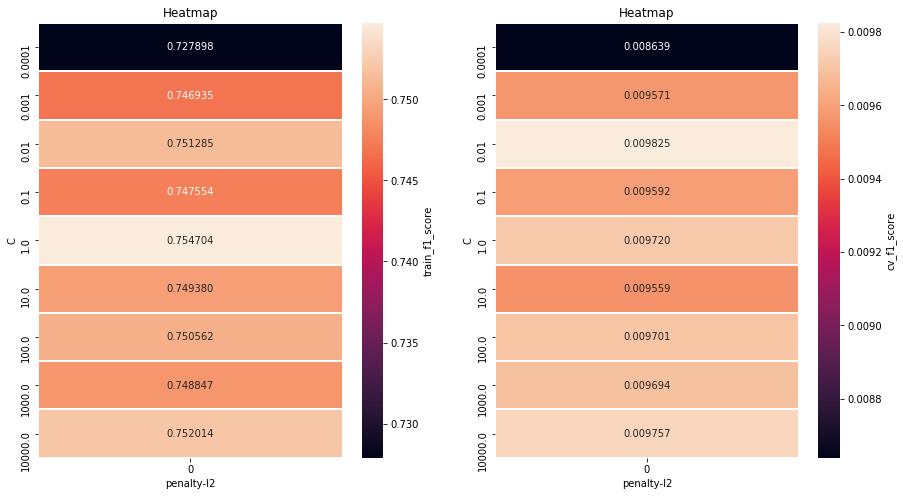

In [103]:
df1=pd.DataFrame(np.array(train_f1_scores),index=c_range)
df2=pd.DataFrame(np.array(cv_f1_scores),index=c_range)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(xlabel='penalty-l2', ylabel='C',title='Heatmap')
plt.show()

__From the above heatmap, we can observe that cv f1 score is high when C=0.01.__

In [104]:
test_f1_scores=[]
LR_model=LogisticRegression(C=0.01,penalty='l2')
LR_model.fit(train_standardized,train_output)
predicted_test_failure=LR_model.predict(test_standardized)
predicted_test_failure_prob=LR_model.predict(test_standardized)
test_f1_scores.append(f1_score(test_output, predicted_test_failure))
print("test Precison :",precision_score(test_output,predicted_test_failure))
print("test Recall :",recall_score(test_output,predicted_test_failure))
print("test_f1_score=",test_f1_scores[-1])

test Precison : 0.004871530774155833
test Recall : 0.6750241080038573
test_f1_score= 0.009673251387075154


Number of misclassified points  14.180628412110755
------------------------- Confusion matrix -------------------------


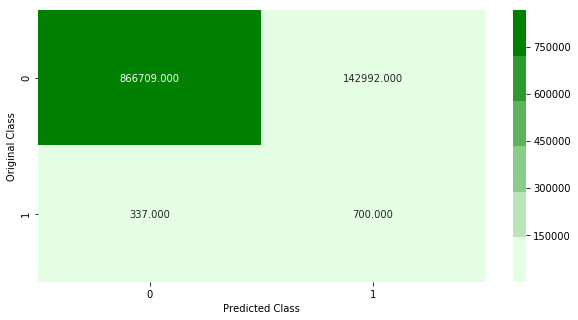

------------------------- Precision matrix -------------------------


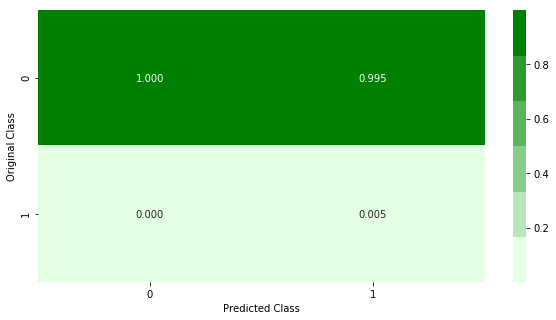

Sum of columns in precision matrix [1. 1.]
------------------------- Recall matrix -------------------------


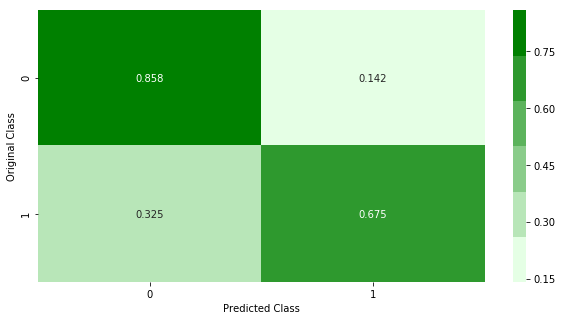

Sum of rows in precision matrix [1. 1.]


In [105]:
plot_confusion_matrix(test_output, predicted_test_failure)

__Summary:__
1. From the above heatmap and confusion matrix, we can observe that f1 score is very less with logistic regression.
2. For c=0.01 and with penalty='l2', we got the best test f1 score.
    
    train_f1_score=0.751285
    
    cv_f1_score=0.009825
    
    test_f1_score=0.009673

### 9.2. Support Vector Machine

In [82]:
alpha_range=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
train_f1_scores=[]
cv_f1_scores=[]
for a in alpha_range:
    print("For alpha=",a)
    SGD_model=SGDClassifier(loss='hinge',alpha=a)
    SGD_model.fit(train_standardized,train_output)
    
    predicted_train_failure=SGD_model.predict(train_standardized)
    train_f1_scores.append(f1_score(train_output, predicted_train_failure))
    print("Train Precison :",precision_score(train_output,predicted_train_failure))
    print("Train Recall :",recall_score(train_output,predicted_train_failure))
    print("train_f1_score=",train_f1_scores[-1])
    print("-"*50)
    
    predicted_cv_failure=SGD_model.predict(cv_standardized)
    cv_f1_scores.append(f1_score(cv_output, predicted_cv_failure))
    print("cv Precison :",precision_score(cv_output,predicted_cv_failure))
    print("cv Recall :",recall_score(cv_output,predicted_cv_failure))
    print("cv_f1_score=",cv_f1_scores[-1])
    print("-"*50)
    
    print("-"*50)

For alpha= 0.0001
Train Precison : 0.8513812725611335
Train Recall : 0.6808358786930412
train_f1_score= 0.7566171888005481
--------------------------------------------------
cv Precison : 0.0056329553824289134
cv Recall : 0.6542168674698795
cv_f1_score= 0.011169736801505754
--------------------------------------------------
--------------------------------------------------
For alpha= 0.001
Train Precison : 0.8483589610086968
Train Recall : 0.6444850780382682
train_f1_score= 0.7325007527768319
--------------------------------------------------
cv Precison : 0.005507785763175907
cv Recall : 0.6204819277108434
cv_f1_score= 0.010918650751584796
--------------------------------------------------
--------------------------------------------------
For alpha= 0.01
Train Precison : 0.7021280976179047
Train Recall : 0.7388505816852329
train_f1_score= 0.7200214143257314
--------------------------------------------------
cv Precison : 0.0023958869298476453
cv Recall : 0.7349397590361446
cv_f1_sco

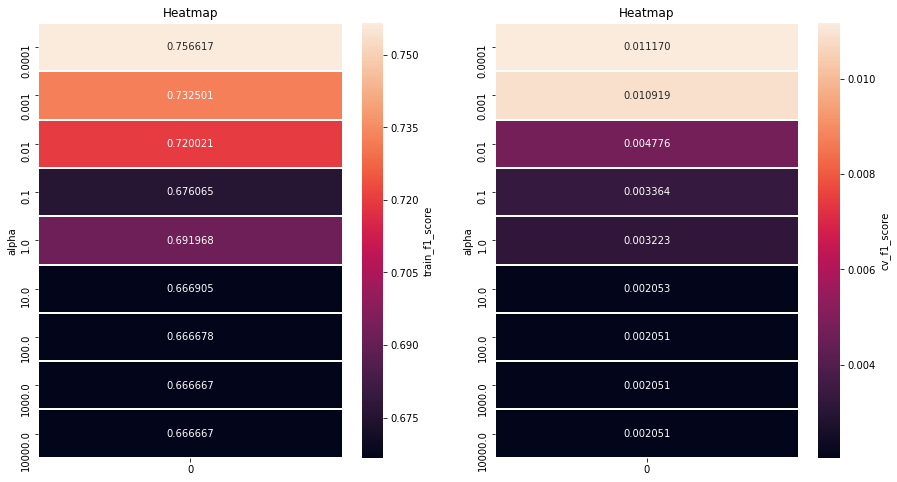

In [83]:
df1=pd.DataFrame(np.array(train_f1_scores),index=alpha_range)
df2=pd.DataFrame(np.array(cv_f1_scores),index=alpha_range)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(ylabel='alpha',title='Heatmap')
plt.show()

__From above heatmap, we can observe that f1 score is more for train and cv when alpha=0.0001.__

In [106]:
test_f1_scores=[]
SGD_model=SGDClassifier(loss='hinge',alpha=0.0001)
SGD_model.fit(train_standardized,train_output)
predicted_test_failure=SGD_model.predict(test_standardized)
test_f1_scores.append(f1_score(test_output, predicted_test_failure))
print("test Precison :",precision_score(test_output,predicted_test_failure))
print("test Recall :",recall_score(test_output,predicted_test_failure))
print("test_f1_score=",test_f1_scores[-1])

test Precison : 0.00566737680241501
test Recall : 0.6644165863066538
test_f1_score= 0.011238887529565289


Number of misclassified points  11.994404088893463
------------------------- Confusion matrix -------------------------


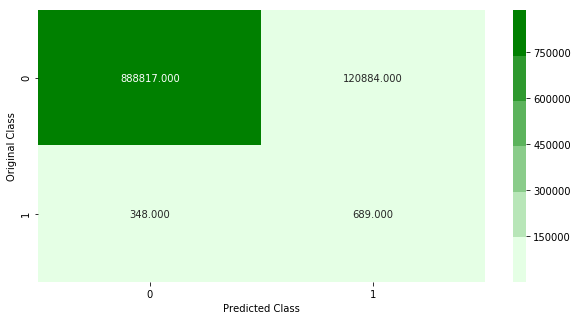

------------------------- Precision matrix -------------------------


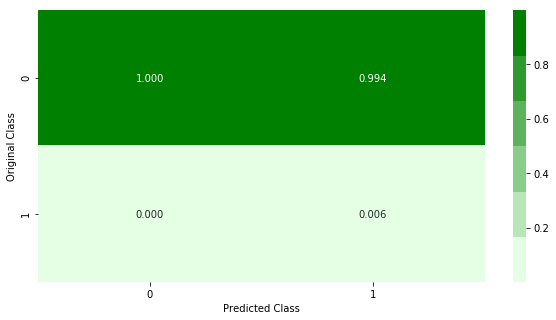

Sum of columns in precision matrix [1. 1.]
------------------------- Recall matrix -------------------------


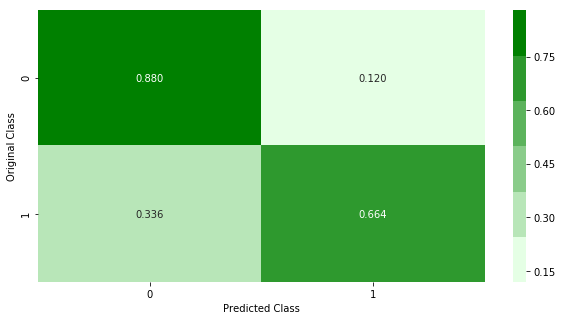

Sum of rows in precision matrix [1. 1.]


In [107]:
plot_confusion_matrix(test_output, predicted_test_failure)

__Summary:__
1. From the above heatmap, scores and confusion matrix, we can observe that test f1 score is less with SVM.
2. For alpha=0.0001, we got the best test f1 score.

    train_f1_score=0.756617
    
    cv_f1_score=0.011170

    test_f1_score=0.01123

### 9.3. Random Forest Classifier

In [110]:
n_estimators = [100,150,200]
max_depth = [7,  9]
train_f1_scores=np.zeros((len(n_estimators),len(max_depth)),dtype=float)
cv_f1_scores=np.zeros((len(n_estimators),len(max_depth)),dtype=float)
k=0
for i in n_estimators:
    print("For n_estimators:",i)
    train_f1_score=[]
    cv_f1_score=[]
    for j in max_depth:
        rf_model = RandomForestClassifier(n_estimators=i, max_depth=j)
        rf_model.fit(train_df_final_1,train_output)
        cal_rf_model=CalibratedClassifierCV(rf_model,method='isotonic',cv='prefit')
        cal_rf_model.fit(cv_df_final_1,cv_output)

        train_scores=cal_rf_model.predict(train_df_final_1)
        train_f1_score.append(f1_score(train_output,train_scores))
        print("For max_depth=%d, train f1_score=%f" % (j,train_f1_score[-1]))
        print("Train Precison :",precision_score(train_output,train_scores))
        print("Train Recall :",recall_score(train_output,train_scores))
        

        cv_scores=cal_rf_model.predict(cv_df_final_1)
        cv_f1_score.append(f1_score(cv_output,cv_scores))
        print("For max_depth=%d, cv f1_score=%f" % (j,cv_f1_score[-1]))
        print("cv Precison :",precision_score(cv_output,cv_scores))
        print("cv Recall :",recall_score(cv_output,cv_scores))
        print("--"*50)
    

    train_f1_scores[k]=train_f1_scores[k]+np.array(train_f1_score)
    cv_f1_scores[k]=cv_f1_scores[k]+np.array(cv_f1_score)
    print("train_f1_scores: ",train_f1_scores[k])
    print("cv_f1_scores: ",cv_f1_scores[k])
    print("--"*50)
    k+=1

For n_estimators: 100
For max_depth=7, train f1_score=0.112667
Train Precison : 0.9991505011525214
Train Recall : 0.05969929833802893
For max_depth=7, cv f1_score=0.087527
cv Precison : 0.47619047619047616
cv Recall : 0.04819277108433735
----------------------------------------------------------------------------------------------------
For max_depth=9, train f1_score=0.132744
Train Precison : 0.9990953335739978
Train Recall : 0.07109499935469754
For max_depth=9, cv f1_score=0.110521
cv Precison : 0.46846846846846846
cv Recall : 0.06265060240963856
----------------------------------------------------------------------------------------------------
train_f1_scores:  [0.11266675 0.13274402]
cv_f1_scores:  [0.08752735 0.11052072]
----------------------------------------------------------------------------------------------------
For n_estimators: 150
For max_depth=7, train f1_score=0.087698
Train Precison : 0.9996896568009014
Train Recall : 0.04586042339888389
For max_depth=7, cv f1_score

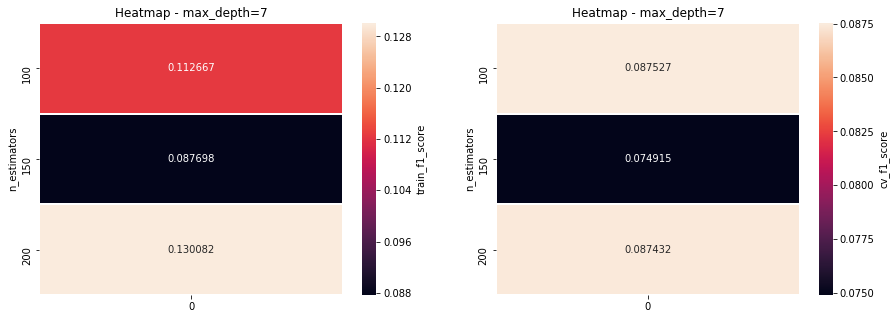

In [120]:
df1=pd.DataFrame(train_f1_scores[:,0],index=n_estimators)
df2=pd.DataFrame(cv_f1_scores[:,0],index=n_estimators)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(ylabel='n_estimators',title='Heatmap - max_depth=7')
plt.show()

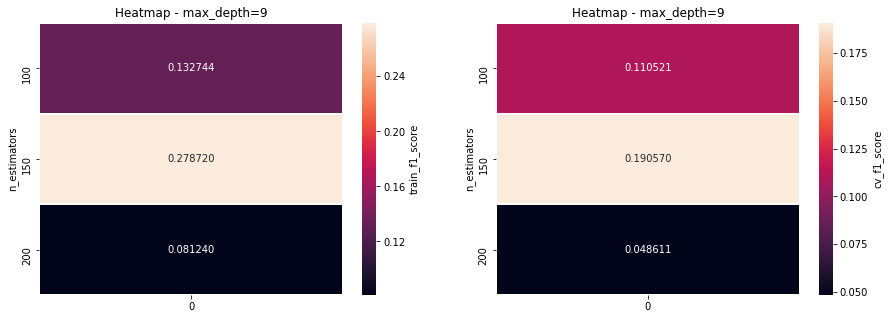

In [121]:
df1=pd.DataFrame(train_f1_scores[:,1],index=n_estimators)
df2=pd.DataFrame(cv_f1_scores[:,1],index=n_estimators)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(ylabel='n_estimators',title='Heatmap - max_depth=9')
plt.show()

__From the above heatmaps, we can observe that f1 score is high when n_estimators=150 and max_depth=9.__

In [122]:
test_f1_score=[]
rf_model = RandomForestClassifier(n_estimators=150, max_depth=9)
rf_model.fit(train_df_final_1,train_output)
cal_rf_model=CalibratedClassifierCV(rf_model,method='isotonic',cv='prefit')
cal_rf_model.fit(cv_df_final_1,cv_output)

test_scores=cal_rf_model.predict(test_df_final_1)
test_f1_score.append(f1_score(test_output,test_scores))
print("test f1_score: ",test_f1_score[-1])
print("test Precison :",precision_score(test_output,test_scores))
print("test Recall :",recall_score(test_output,test_scores))

test f1_score:  0.026515151515151516
test Precison : 0.7368421052631579
test Recall : 0.013500482160077145


Number of misclassified points  0.10170786098870331
------------------------- Confusion matrix -------------------------


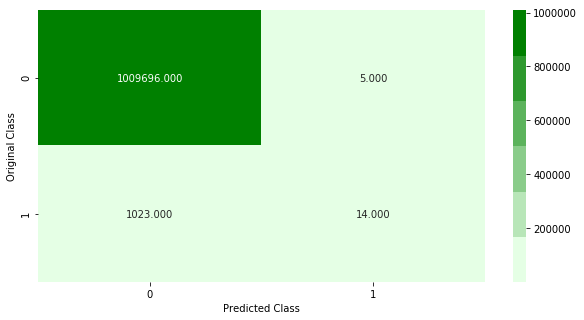

------------------------- Precision matrix -------------------------


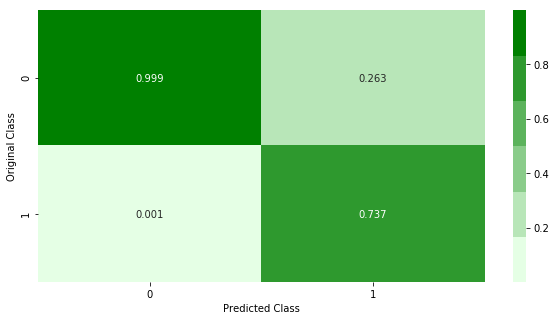

Sum of columns in precision matrix [1. 1.]
------------------------- Recall matrix -------------------------


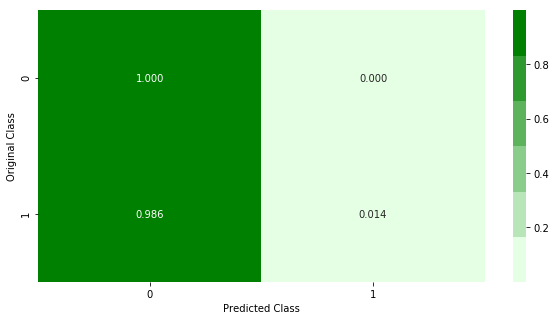

Sum of rows in precision matrix [1. 1.]


In [123]:
plot_confusion_matrix(test_output, test_scores)

__Summary:__
1. From the above heatmaps, scores and confusion matrix, we can observe that test f1 score is less with RandomForestClassifier.
2. For n_estiamtors=150, max_depth=9, we got the best test f1 score.

    train_f1_score=0.27872

    cv_f1_score=0.19057

    test_f1_score=0.02651

### 9.4. XGBoost

In [116]:
import warnings 
warnings.filterwarnings("ignore") 

In [126]:
#df_new=pd.read_csv('df_segate_july_august_no_backtrack.csv') rolling_mean 15, rolling_stdev 15,  exp_avg alpha=0.15, 
#expanding_mean, expanding_stdev
#upsampling, train_test_split 0.2, 15 days backtrack, model_char_count, second_last chars, 
#serial second_last chars only working, calibration
n_estimators = [100, 150, 200]
max_depth = [7, 9]
train_f1_scores=np.zeros((len(n_estimators),len(max_depth)),dtype=float)
cv_f1_scores=np.zeros((len(n_estimators),len(max_depth)),dtype=float)
k=0
for i in n_estimators:
    print("For n_estimators:",i)
    train_f1_score=[]
    cv_f1_score=[]
    for j in max_depth:
        xgb_model = xgb.XGBClassifier(n_estimators=i, max_depth=j,tree_method='exact')
        xgb_model.fit(train_df_final_1,train_output)
        cal_xgb_model=CalibratedClassifierCV(xgb_model,method='isotonic',cv='prefit')
        cal_xgb_model.fit(cv_df_final_1,cv_output)

        train_scores=cal_xgb_model.predict(train_df_final_1)
        train_f1_score.append(f1_score(train_output,train_scores))
        print("For max_depth=%d, train f1_score=%f" % (j,train_f1_score[-1]))
        print("Train Precison :",precision_score(train_output,train_scores))
        print("Train Recall :",recall_score(train_output,train_scores))
        print("--"*50)
        
        cv_scores=cal_xgb_model.predict(cv_df_final_1)
        cv_f1_score.append(f1_score(cv_output,cv_scores))
        print("For max_depth=%d, cv f1_score=%f" % (j,cv_f1_score[-1]))
        print("cv Precison :",precision_score(cv_output,cv_scores))
        print("cv Recall :",recall_score(cv_output,cv_scores ))
        print("--"*50)

    print("--"*50)
    train_f1_scores[k]=train_f1_scores[k]+np.array(train_f1_score)
    cv_f1_scores[k]=cv_f1_scores[k]+np.array(cv_f1_score)
    print("train_f1_scores: ",train_f1_scores[k])
    print("cv_f1_scores: ",cv_f1_scores[k])
    k+=1

For n_estimators: 100
For max_depth=7, train f1_score=0.999203
Train Precison : 0.9999401788002967
Train Recall : 0.9984664394748074
----------------------------------------------------------------------------------------------------
For max_depth=7, cv f1_score=0.860987
cv Precison : 0.9192886456908345
cv Recall : 0.8096385542168675
----------------------------------------------------------------------------------------------------
For max_depth=9, train f1_score=0.999995
Train Precison : 0.9999904056669702
Train Recall : 1.0
----------------------------------------------------------------------------------------------------
For max_depth=9, cv f1_score=0.922693
cv Precison : 0.9560723514211886
cv Recall : 0.891566265060241
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
train_f1_scores:  [0.99920277 0.9999952 ]
cv_f1_scores:  [0.860

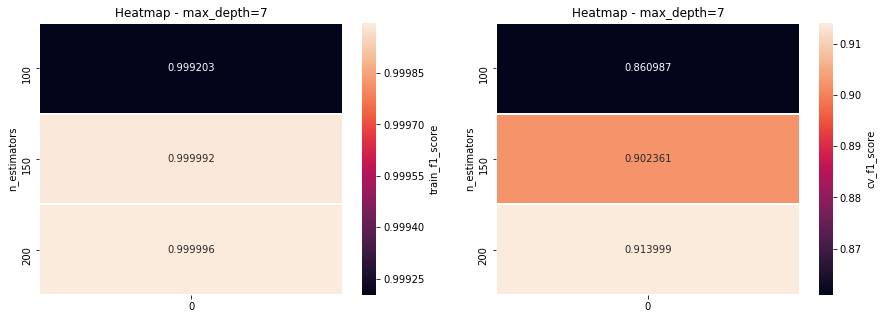

In [131]:
n_estimators = [100, 150, 200]
df1=pd.DataFrame(train_f1_scores[:,0],index=n_estimators)
df2=pd.DataFrame(cv_f1_scores[:,0],index=n_estimators)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(ylabel='n_estimators',title='Heatmap - max_depth=7')
plt.show()

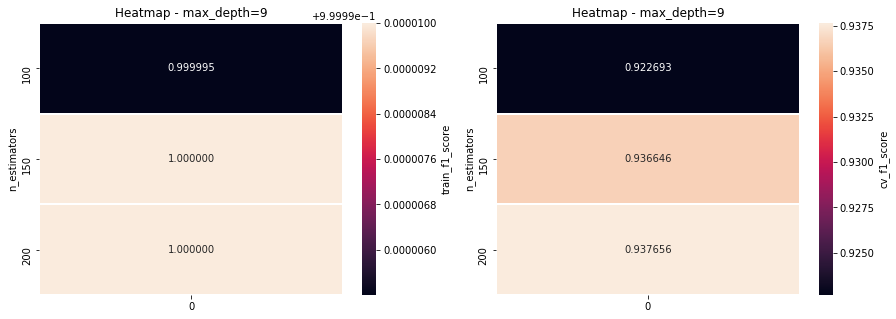

In [132]:
n_estimators = [100, 150, 200]
df1=pd.DataFrame(train_f1_scores[:,1],index=n_estimators)
df2=pd.DataFrame(cv_f1_scores[:,1],index=n_estimators)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(ylabel='n_estimators',title='Heatmap - max_depth=9')
plt.show()

In [127]:
#df_new=pd.read_csv('df_segate_july_august_no_backtrack.csv') rolling_mean 15, rolling_stdev 15,  exp_avg alpha=0.15, 
#expanding_mean, expanding_stdev
#upsampling, train_test_split 0.2, 15 days backtrack, model_char_count, second_last chars, 
#serial second_last chars only working, calibration
n_estimators = [500,1000]
max_depth = [7, 9]
train_f1_scores1=np.zeros((len(n_estimators),len(max_depth)),dtype=float)
cv_f1_scores1=np.zeros((len(n_estimators),len(max_depth)),dtype=float)
k=0
for i in n_estimators:
    print("For n_estimators:",i)
    train_f1_score=[]
    cv_f1_score=[]
    for j in max_depth:
        xgb_model = xgb.XGBClassifier(n_estimators=i, max_depth=j,tree_method='exact')
        xgb_model.fit(train_df_final_1,train_output)
        cal_xgb_model=CalibratedClassifierCV(xgb_model,method='isotonic',cv='prefit')
        cal_xgb_model.fit(cv_df_final_1,cv_output)

        train_scores1=cal_xgb_model.predict(train_df_final_1)
        train_f1_score.append(f1_score(train_output,train_scores1))
        print("For max_depth=%d, train f1_score=%f" % (j,train_f1_score[-1]))
        print("Train Precison :",precision_score(train_output,train_scores1))
        print("Train Recall :",recall_score(train_output,train_scores1))
        print("--"*50)
        
        cv_scores1=cal_xgb_model.predict(cv_df_final_1)
        cv_f1_score.append(f1_score(cv_output,cv_scores1))
        print("For max_depth=%d, cv f1_score=%f" % (j,cv_f1_score[-1]))
        print("cv Precison :",precision_score(cv_output,cv_scores1))
        print("cv Recall :",recall_score(cv_output,cv_scores1 ))
        print("--"*50)

    print("--"*50)
    train_f1_scores1[k]=train_f1_scores1[k]+np.array(train_f1_score)
    cv_f1_scores1[k]=cv_f1_scores1[k]+np.array(cv_f1_score)
    print("train_f1_scores1: ",train_f1_scores1[k])
    print("cv_f1_scores1: ",cv_f1_scores1[k])
    k+=1

For n_estimators: 500
For max_depth=7, train f1_score=1.000000
Train Precison : 1.0
Train Recall : 1.0
----------------------------------------------------------------------------------------------------
For max_depth=7, cv f1_score=0.938075
cv Precison : 0.9550561797752809
cv Recall : 0.9216867469879518
----------------------------------------------------------------------------------------------------
For max_depth=9, train f1_score=1.000000
Train Precison : 1.0
Train Recall : 1.0
----------------------------------------------------------------------------------------------------
For max_depth=9, cv f1_score=0.943258
cv Precison : 0.9555006180469716
cv Recall : 0.9313253012048193
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
train_f1_scores1:  [1. 1.]
cv_f1_scores1:  [0.9380748  0.94325808]
For n_estimators: 1000
For max_depth=7, 

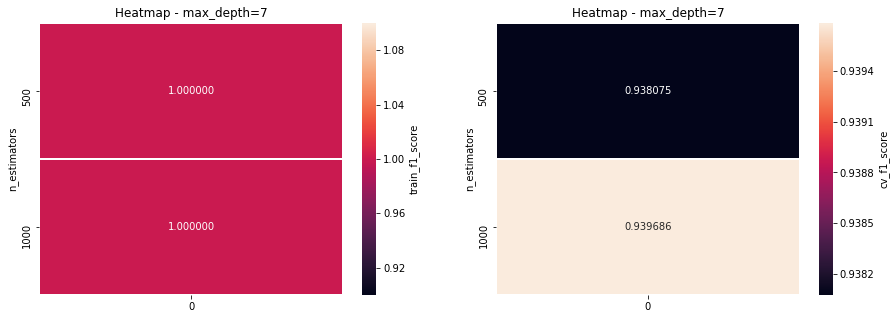

In [133]:
n_estimators = [500,1000]
df1=pd.DataFrame(train_f1_scores1[:,0],index=n_estimators)
df2=pd.DataFrame(cv_f1_scores1[:,0],index=n_estimators)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(ylabel='n_estimators',title='Heatmap - max_depth=7')
plt.show()

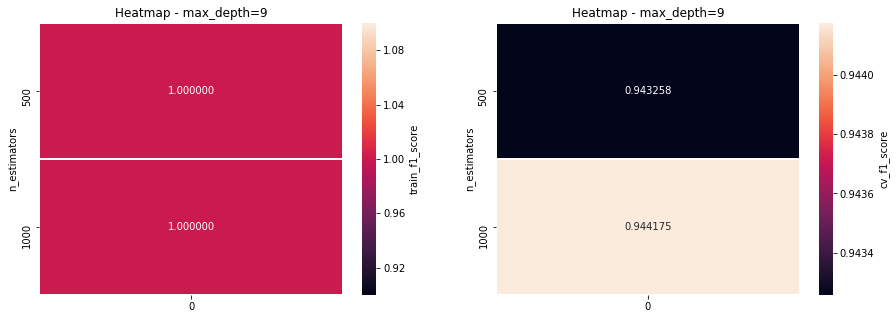

In [134]:
n_estimators = [500,1000]
df1=pd.DataFrame(train_f1_scores1[:,1],index=n_estimators)
df2=pd.DataFrame(cv_f1_scores1[:,1],index=n_estimators)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(ylabel='n_estimators',title='Heatmap - max_depth=9')
plt.show()

__From the above heatmaps, we can observe that f1_score is high when n_estimators=1000 and max_depth=9.__

In [137]:
test_f1_score=[]
xgb_model = xgb.XGBClassifier(n_estimators=1000, max_depth=9,tree_method='exact')
xgb_model.fit(train_df_final_1,train_output)
cal_xgb_model=CalibratedClassifierCV(xgb_model,method='isotonic',cv='prefit')
cal_xgb_model.fit(cv_df_final_1,cv_output)

test_scores1=cal_xgb_model.predict(test_df_final_1)
test_f1_score.append(f1_score(test_output,test_scores1))
print("For max_depth=%d, test f1_score=%f" % (j,test_f1_score[-1]))
print("test Precison :",precision_score(test_output,test_scores1))
print("test Recall :",recall_score(test_output,test_scores1))

For max_depth=9, test f1_score=0.929026
test Precison : 0.9433399602385686
test Recall : 0.9151398264223722


In [560]:
pickle.dump(xgb_model, open("xgb_model.pickle.dat", "wb"))

In [493]:
pickle.dump(cal_xgb_model, open("cal_xgb_model.pickle.dat", "wb"))

In [68]:
important_features=xgb_model.get_booster().get_score(importance_type="gain")

In [69]:
important_features_sorted=sorted(important_features.items(),key=lambda x:x[1], reverse=True)

In [74]:
important_features_sorted

[('f77', 9692.977239721255),
 ('f4', 6359.347152843716),
 ('f12', 4779.306769969225),
 ('f1', 2079.053004797285),
 ('f3', 1277.837001635879),
 ('f68', 1048.994886625),
 ('f2', 709.2985122393505),
 ('f55', 603.2786218767542),
 ('f22', 570.2189044686388),
 ('f26', 559.76121196902),
 ('f14', 489.78788185749994),
 ('f54', 466.51603533607937),
 ('f8', 412.79072825003277),
 ('f0', 381.06343606598404),
 ('f6', 379.1382587549423),
 ('f29', 378.14108987462674),
 ('f67', 376.2934444462),
 ('f49', 372.27258422541485),
 ('f57', 352.34981679930684),
 ('f25', 351.4389383427062),
 ('f56', 338.3375441982692),
 ('f52', 337.4384088433705),
 ('f75', 334.6363965230835),
 ('f51', 321.57605896499336),
 ('f70', 319.53477706700187),
 ('f15', 317.5317400937668),
 ('f45', 304.0135950212239),
 ('f43', 296.0832564557593),
 ('f69', 292.6682935782657),
 ('f38', 289.57140919818585),
 ('f31', 286.96653661962154),
 ('f74', 285.295164720459),
 ('f20', 282.7870663048318),
 ('f61', 278.7656793955133),
 ('f16', 265.464532

In [70]:
index_features=dict()
i=0
for column in train_df_final.columns:
    index_features['f'+str(i)]=column 
    i+=1

In [71]:
sorted_important_features_dict=dict()
for i in important_features_sorted:
    key=i[0]
    sorted_important_features_dict[key]=index_features[key]

In [72]:
print("Top 10 important features:")
list(sorted_important_features_dict.items())[0:10]

Top 10 important features:


[('f77', 'smart_188_raw_exp_avg'),
 ('f4', 'smart_5_raw'),
 ('f12', 'smart_197_raw'),
 ('f1', 'model_second_last_char_working'),
 ('f3', 'capacity_bytes'),
 ('f68', 'smart_199_raw_expanding_stdev'),
 ('f2', 'serial_second_last_char_working'),
 ('f55', 'smart_188_raw_expanding_mean'),
 ('f22', 'smart_9_raw_rolling_mean'),
 ('f26', 'smart_12_raw_rolling_stdev')]

Number of misclassified points  0.014345953155021381
------------------------- Confusion matrix -------------------------


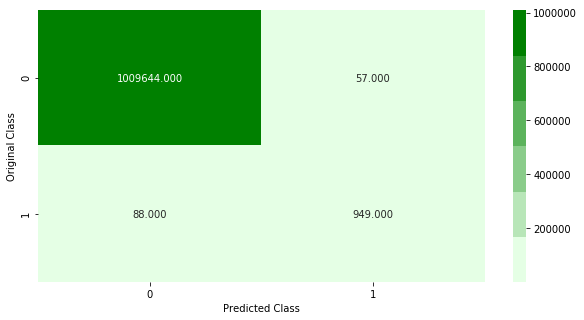

------------------------- Precision matrix -------------------------


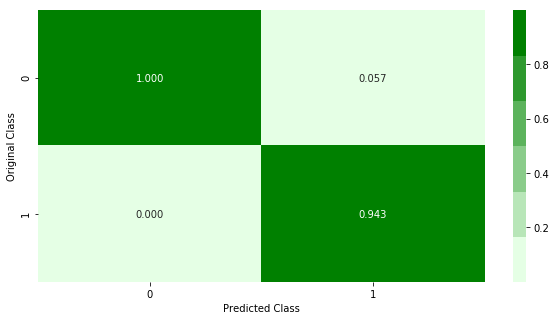

Sum of columns in precision matrix [1. 1.]
------------------------- Recall matrix -------------------------


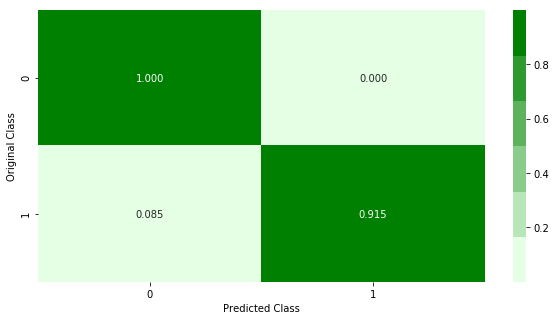

Sum of rows in precision matrix [1. 1.]


In [145]:
plot_confusion_matrix(test_output, test_scores1)

__Summary:__
1. From the above heatmaps, scores and confusion matrix, we can observe that XGBoost performed very well in predicting failed hard drives.
2. Optimal hyper-parameters: n_estimators=1000, max_depth=9

    test f1_score: 0.929026
    
    test Precison : 0.943334
    
    test Recall : 0.915139

### 9.5. Naive Bayes

In [93]:
alpha_range=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
train_f1_scores=[]
cv_f1_scores=[]
for a in alpha_range:
    print("For alpha=",a)
    nb_clf=MultinomialNB(alpha=a, fit_prior=True)
    nb_clf.fit(train_normalized,train_output)
    
    predicted_train_failure=nb_clf.predict(train_normalized)
    train_f1_scores.append(f1_score(train_output, predicted_train_failure))
    print("Train Precison :",precision_score(train_output,predicted_train_failure))
    print("Train Recall :",recall_score(train_output,predicted_train_failure))
    print("train_f1_score=",train_f1_scores[-1])
    print("-"*50)
    
    predicted_cv_failure=nb_clf.predict(cv_normalized)
    cv_f1_scores.append(f1_score(cv_output, predicted_cv_failure))
    print("cv Precison :",precision_score(cv_output,predicted_cv_failure))
    print("cv Recall :",recall_score(cv_output,predicted_cv_failure))
    print("cv_f1_score=",cv_f1_scores[-1])
    print("-"*50)
    
    print("-"*50)

For alpha= 0.0001
Train Precison : 0.7004530556607403
Train Recall : 0.5650642841955369
train_f1_score= 0.625516525209308
--------------------------------------------------
cv Precison : 0.002240767679861164
cv Recall : 0.5289156626506024
cv_f1_score= 0.004462629291722788
--------------------------------------------------
--------------------------------------------------
For alpha= 0.001
Train Precison : 0.7004530556607403
Train Recall : 0.5650642841955369
train_f1_score= 0.625516525209308
--------------------------------------------------
cv Precison : 0.002240767679861164
cv Recall : 0.5289156626506024
cv_f1_score= 0.004462629291722788
--------------------------------------------------
--------------------------------------------------
For alpha= 0.01
Train Precison : 0.7004533243916606
Train Recall : 0.5650642841955369
train_f1_score= 0.6255166323629802
--------------------------------------------------
cv Precison : 0.002240767679861164
cv Recall : 0.5289156626506024
cv_f1_score= 

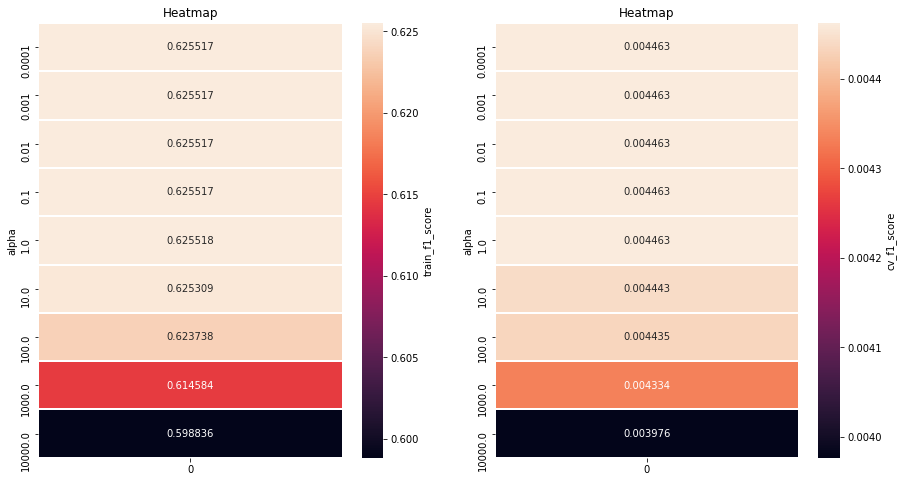

In [94]:
df1=pd.DataFrame(np.array(train_f1_scores),index=alpha_range)
df2=pd.DataFrame(np.array(cv_f1_scores),index=alpha_range)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(ylabel='alpha',title='Heatmap')
plt.show()

__From the above heatmap, we can observe that f1_score is high when alpha=10.__

In [99]:
test_f1_scores=[]
nb_clf=MultinomialNB(alpha=10, fit_prior=True)
nb_clf.fit(train_normalized,train_output)
    
predicted_test_failure=nb_clf.predict(test_normalized)
test_f1_scores.append(f1_score(test_output, predicted_test_failure))
print("test Precison :",precision_score(test_output,predicted_test_failure))
print("test Recall :",recall_score(test_output,predicted_test_failure))
print("test_f1_score=",test_f1_scores[-1])

test Precison : 0.0024734361138025913
test Recall : 0.583413693346191
test_f1_score= 0.004925988047354623


Number of misclassified points  24.18292376461556
------------------------- Confusion matrix -------------------------


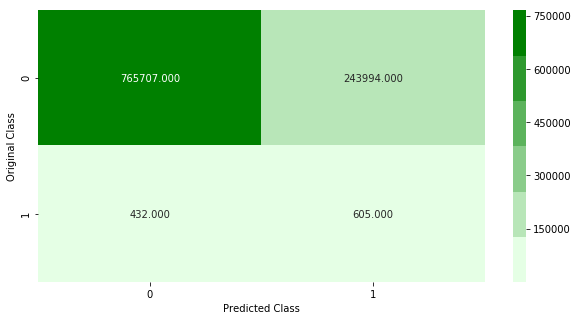

------------------------- Precision matrix -------------------------


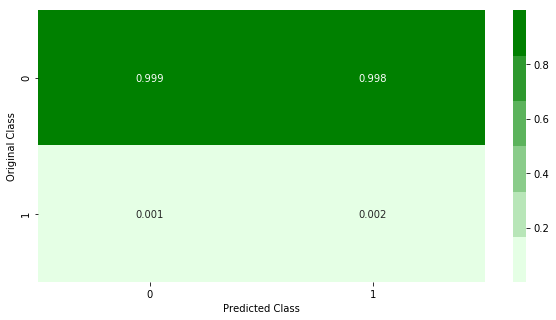

Sum of columns in precision matrix [1. 1.]
------------------------- Recall matrix -------------------------


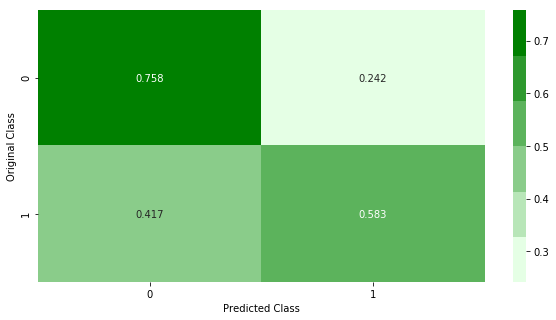

Sum of rows in precision matrix [1. 1.]


In [100]:
plot_confusion_matrix(test_output, predicted_test_failure)

__Summary:__
1. From the above heatmap, scores and confusion matrix, we can observe that test f1 score is less with Naive Bayes.
2. For alpha=0.0001, we got the best test f1 score.

    train_f1_score=0.625518

    cv_f1_score=0.004463

    test_f1_score=0.004925

## 10. Modelling with top 50 important features

In [87]:
top_50_features=list(sorted_important_features_dict.values())[:50]

In [484]:
with open("top_50_features.txt","wb") as fp:
    pickle.dump(top_50_features,fp)

In [37]:
with open("top_50_features.txt","rb") as fp:
    top_50_features=pickle.load(fp)

In [38]:
train_df_final_imp=train_df_final[top_50_features]
train_df_final_imp.head(2)

,smart_188_raw_exp_avg,smart_5_raw,smart_197_raw,model_second_last_char_working,capacity_bytes,smart_199_raw_expanding_stdev,serial_second_last_char_working,smart_188_raw_expanding_mean,smart_9_raw_rolling_mean,smart_12_raw_rolling_stdev,...,mean,smart_193_raw_expanding_stdev,smart_9_raw_expanding_stdev,smart_5_raw_expanding_stdev,smart_242_raw_expanding_stdev,smart_242_raw_exp_avg,smart_190_raw,smart_242_raw_rolling_stdev,smart_188_raw_rolling_stdev,smart_241_raw_rolling_stdev
0,0.0,0.0,0.0,0.998382,12000138625024,0.0,0.999463,0.0,4654.133333,0.507093,...,6.016736e+09,13291.091432,246.460926,0.0,2.359002e+09,4.101401e+10,23.0,1.003422e+09,0.0,4.459660e+08
1,0.0,0.0,0.0,0.999412,4000787030016,0.0,0.999579,0.0,32015.000000,9.000000,...,1.443228e+10,625.000000,32015.000000,0.0,1.374864e+11,1.374864e+11,21.0,1.374864e+11,0.0,5.013317e+10


In [39]:
cv_df_final_imp=cv_df_final[top_50_features]
cv_df_final_imp.head(2)

,smart_188_raw_exp_avg,smart_5_raw,smart_197_raw,model_second_last_char_working,capacity_bytes,smart_199_raw_expanding_stdev,serial_second_last_char_working,smart_188_raw_expanding_mean,smart_9_raw_rolling_mean,smart_12_raw_rolling_stdev,...,mean,smart_193_raw_expanding_stdev,smart_9_raw_expanding_stdev,smart_5_raw_expanding_stdev,smart_242_raw_expanding_stdev,smart_242_raw_exp_avg,smart_190_raw,smart_242_raw_rolling_stdev,smart_188_raw_rolling_stdev,smart_241_raw_rolling_stdev
0,0.0,0.0,0.0,0.999412,4000787030016,0.0,0.999001,0.0,33076.6,0.0,...,1.528963e+10,30994.335530,370.807312,0.0,3.175617e+09,1.468110e+11,21.0,1.056709e+09,0.0,8.396638e+07
1,0.0,0.0,0.0,0.998382,12000138625024,0.0,0.999080,0.0,5169.0,0.0,...,4.883302e+09,12357.315172,32.506410,0.0,3.547395e+08,2.234143e+10,34.0,3.547395e+08,0.0,1.664539e+08


In [40]:
test_df_final_imp=test_df_final[top_50_features]
test_df_final_imp.head(2)

,smart_188_raw_exp_avg,smart_5_raw,smart_197_raw,model_second_last_char_working,capacity_bytes,smart_199_raw_expanding_stdev,serial_second_last_char_working,smart_188_raw_expanding_mean,smart_9_raw_rolling_mean,smart_12_raw_rolling_stdev,...,mean,smart_193_raw_expanding_stdev,smart_9_raw_expanding_stdev,smart_5_raw_expanding_stdev,smart_242_raw_expanding_stdev,smart_242_raw_exp_avg,smart_190_raw,smart_242_raw_rolling_stdev,smart_188_raw_rolling_stdev,smart_241_raw_rolling_stdev
0,0.0,0.0,0.0,0.998382,12000138625024,0.0,0.999364,0.0,11350.066667,0.258199,...,1.147123e+10,19382.482495,240.128256,0.0,2.996227e+09,9.611995e+10,34.0,1.310010e+09,0.0,2.725978e+08
1,0.0,0.0,0.0,0.999412,4000787030016,0.0,0.999116,0.0,37149.866667,0.000000,...,1.525524e+10,8513.501658,351.459288,0.0,3.045829e+09,1.372787e+11,18.0,1.119386e+09,0.0,1.078994e+08


In [41]:
train_df_final_imp_1=train_df_final_imp.as_matrix()
cv_df_final_imp_1=cv_df_final_imp.as_matrix()
test_df_final_imp_1=test_df_final_imp.as_matrix()

#### Data Standardization - for Logisitc Regression, SVM as they calculate l1,l2 distances

In [98]:
scaler = StandardScaler()
train_standardized_imp=scaler.fit_transform(train_df_final_imp)
cv_standardized_imp=scaler.transform(cv_df_final_imp)
test_standardized_imp=scaler.transform(test_df_final_imp)
print(train_standardized_imp.shape)
print(cv_standardized_imp.shape)
print(test_standardized_imp.shape)

(6462086, 50)
(808591, 50)
(1010738, 50)


#### Data Normalization - for Naive Bayes

In [99]:
##MultinomailNB won't accept inputs with negative values.  So, normalizing the original data
scaler = MinMaxScaler()
train_normalized_imp=scaler.fit_transform(train_df_final_imp)
cv_normalized_imp=scaler.transform(cv_df_final_imp)
test_normalized_imp=scaler.transform(test_df_final_imp)
print(train_normalized_imp.shape)
print(cv_normalized_imp.shape)
print(test_normalized_imp.shape)

(6462086, 50)
(808591, 50)
(1010738, 50)


__For RandomForests and XGBoost, we can directly use the data without any standardization or normalization as these are based on decision trees.__

### 10.1. Logistic Regression

In [100]:
c_range=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
penalty=['l2']
train_f1_scores_LR=[]
cv_f1_scores_LR=[]
for c in c_range:
    for p in penalty:
        print("For c=",c," penalty=",p)
        LR_model=LogisticRegression(C=c,penalty=p)
        LR_model.fit(train_standardized_imp,train_output)
        
        predicted_train_failure=LR_model.predict(train_standardized_imp)
        predicted_train_failure_prob=LR_model.predict(train_standardized_imp)
        train_f1_scores_LR.append(f1_score(train_output, predicted_train_failure))
        print("Train Precison :",precision_score(train_output,predicted_train_failure))
        print("Train Recall :",recall_score(train_output,predicted_train_failure))
        print("train_f1_score=",train_f1_scores_LR[-1])
        print("-"*50)
        
        predicted_cv_failure=LR_model.predict(cv_standardized_imp)
        predicted_cv_failure_prob=LR_model.predict(cv_standardized_imp)
        cv_f1_scores_LR.append(f1_score(cv_output, predicted_cv_failure))
        print("cv Precison :",precision_score(cv_output,predicted_cv_failure))
        print("cv Recall :",recall_score(cv_output,predicted_cv_failure))
        print("cv_f1_score=",cv_f1_scores_LR[-1])
        print("-"*50)
        
    print("-"*50)

For c= 0.0001  penalty= l2
Train Precison : 0.7641023535299851
Train Recall : 0.6104895539923176
train_f1_score= 0.678712718237696
--------------------------------------------------
cv Precison : 0.0032489818331579187
cv Recall : 0.5987951807228916
cv_f1_score= 0.006462896860228477
--------------------------------------------------
--------------------------------------------------
For c= 0.001  penalty= l2
Train Precison : 0.7904172066682759
Train Recall : 0.6151651339830513
train_f1_score= 0.6918657026059158
--------------------------------------------------
cv Precison : 0.003718790073168892
cv Recall : 0.5939759036144578
cv_f1_score= 0.007391304347826087
--------------------------------------------------
--------------------------------------------------
For c= 0.01  penalty= l2
Train Precison : 0.779140165831827
Train Recall : 0.5943053063670153
train_f1_score= 0.6742854293533872
--------------------------------------------------
cv Precison : 0.003492093579359467
cv Recall : 0.57

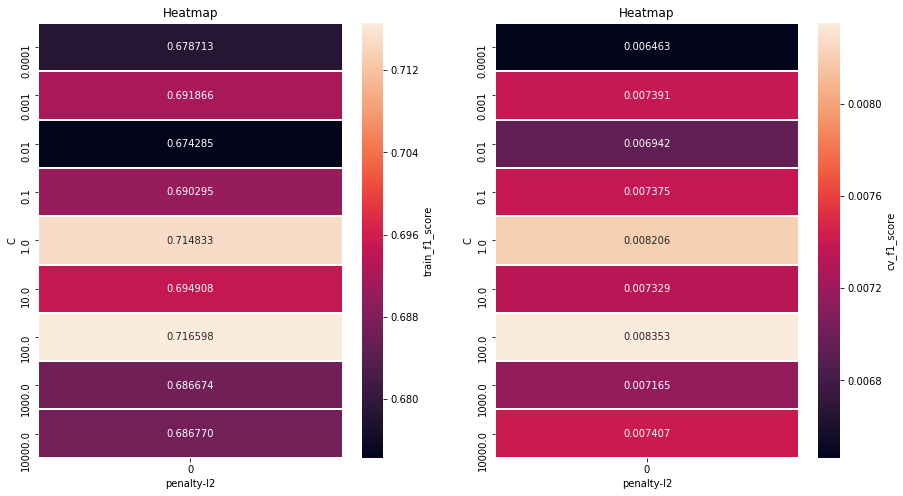

In [102]:
df1=pd.DataFrame(np.array(train_f1_scores_LR),index=c_range)
df2=pd.DataFrame(np.array(cv_f1_scores_LR),index=c_range)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(xlabel='penalty-l2', ylabel='C',title='Heatmap')
plt.show()

__From the above heatmap, we can observe that f1 score is high when c=100.__

In [103]:
test_f1_scores_LR=[]
LR_model=LogisticRegression(C=100,penalty='l2')
LR_model.fit(train_standardized_imp,train_output)
predicted_test_failure=LR_model.predict(test_standardized_imp)
predicted_test_failure_prob=LR_model.predict(test_standardized_imp)
test_f1_scores_LR.append(f1_score(test_output, predicted_test_failure))
print("test Precison :",precision_score(test_output,predicted_test_failure))
print("test Recall :",recall_score(test_output,predicted_test_failure))
print("test_f1_score=",test_f1_scores_LR[-1])

test Precison : 0.004196807863087954
test Recall : 0.6316297010607522
test_f1_score= 0.008338213203656084


Number of misclassified points  15.414281445834627
------------------------- Confusion matrix -------------------------


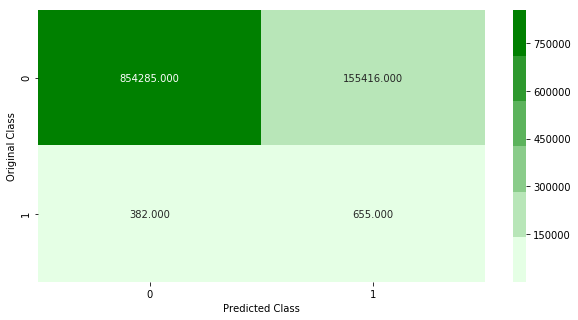

------------------------- Precision matrix -------------------------


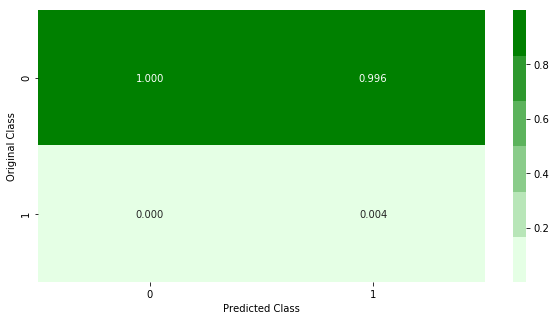

Sum of columns in precision matrix [1. 1.]
------------------------- Recall matrix -------------------------


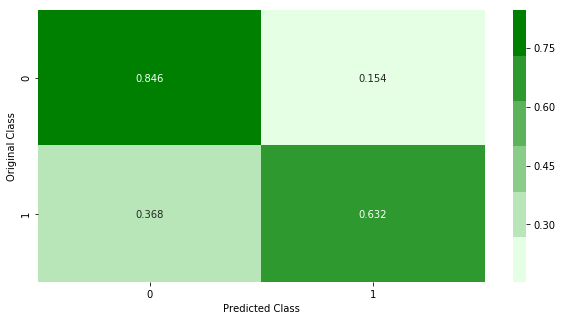

Sum of rows in precision matrix [1. 1.]


In [104]:
plot_confusion_matrix(test_output, predicted_test_failure)

__Summary:__
1. From the above heatmaps, scores, confusion matrix, we can observe that f1 score is less with Logistic Regression.
2. Best f1 score is with C=100, penalty='l2'.

    test_f1_score= 0.008338213203656084

    test Precison : 0.004196807863087954
    
    test Recall : 0.6316297010607522

### 10.2. Support Vector Machine

In [105]:
alpha_range=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
train_f1_scores_svm=[]
cv_f1_scores_svm=[]
for a in alpha_range:
    print("For alpha=",a)
    SGD_model_imp=SGDClassifier(loss='hinge',alpha=a)
    SGD_model_imp.fit(train_standardized_imp,train_output)
    
    predicted_train_failure=SGD_model_imp.predict(train_standardized_imp)
    train_f1_scores_svm.append(f1_score(train_output, predicted_train_failure))
    print("Train Precison :",precision_score(train_output,predicted_train_failure))
    print("Train Recall :",recall_score(train_output,predicted_train_failure))
    print("train_f1_score=",train_f1_scores_svm[-1])
    print("-"*50)
    
    predicted_cv_failure=SGD_model_imp.predict(cv_standardized_imp)
    cv_f1_scores_svm.append(f1_score(cv_output, predicted_cv_failure))
    print("cv Precison :",precision_score(cv_output,predicted_cv_failure))
    print("cv Recall :",recall_score(cv_output,predicted_cv_failure))
    print("cv_f1_score=",cv_f1_scores_svm[-1])
    print("-"*50)
    
    print("-"*50)

For alpha= 0.0001
Train Precison : 0.823342902193137
Train Recall : 0.6243055261102993
train_f1_score= 0.7101413764186753
--------------------------------------------------
cv Precison : 0.004544745081116814
cv Recall : 0.5963855421686747
cv_f1_score= 0.009020747719755438
--------------------------------------------------
--------------------------------------------------
For alpha= 0.001
Train Precison : 0.7953758075609555
Train Recall : 0.5790962856266537
train_f1_score= 0.6702197565432559
--------------------------------------------------
cv Precison : 0.0038135488291084385
cv Recall : 0.5566265060240964
cv_f1_score= 0.0075751986030153234
--------------------------------------------------
--------------------------------------------------
For alpha= 0.01
Train Precison : 0.6283013466838828
Train Recall : 0.732976008056841
train_f1_score= 0.676614227578633
--------------------------------------------------
cv Precison : 0.0016928320653689236
cv Recall : 0.7168674698795181
cv_f1_score

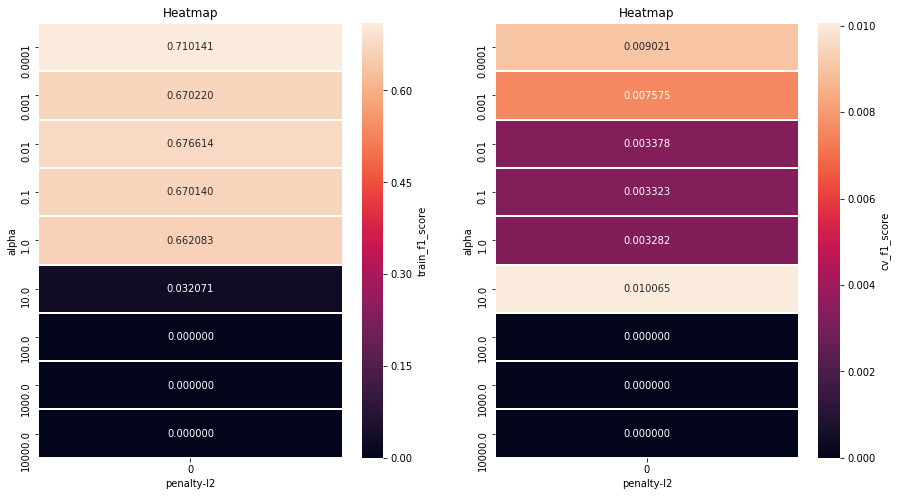

In [107]:
df1=pd.DataFrame(np.array(train_f1_scores_svm),index=alpha_range)
df2=pd.DataFrame(np.array(cv_f1_scores_svm),index=alpha_range)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(xlabel='penalty-l2', ylabel='alpha',title='Heatmap')
plt.show()

__From the above heatmap, we can observe that f1 score is high when alpha=0.0001.__

In [108]:
test_f1_scores_svm=[]
SGD_model_imp=SGDClassifier(loss='hinge',alpha=0.0001)
SGD_model_imp.fit(train_standardized_imp,train_output)
predicted_test_failure=SGD_model_imp.predict(test_standardized_imp)
test_f1_scores_svm.append(f1_score(test_output, predicted_test_failure))
print("test Precison :",precision_score(test_output,predicted_test_failure))
print("test Recall :",recall_score(test_output,predicted_test_failure))
print("test_f1_score=",test_f1_scores_svm[-1])

test Precison : 0.004399131240748682
test Recall : 0.6133076181292189
test_f1_score= 0.008735603766198983


Number of misclassified points  14.280555396156075
------------------------- Confusion matrix -------------------------


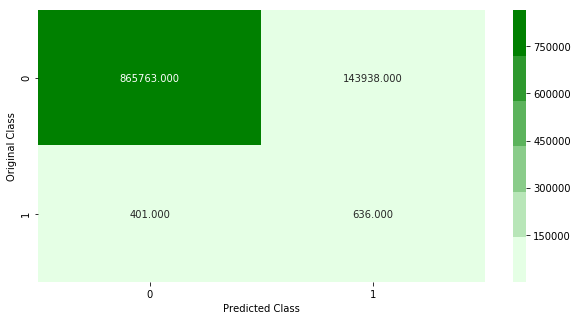

------------------------- Precision matrix -------------------------


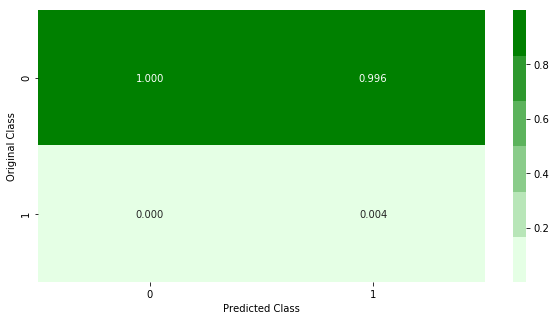

Sum of columns in precision matrix [1. 1.]
------------------------- Recall matrix -------------------------


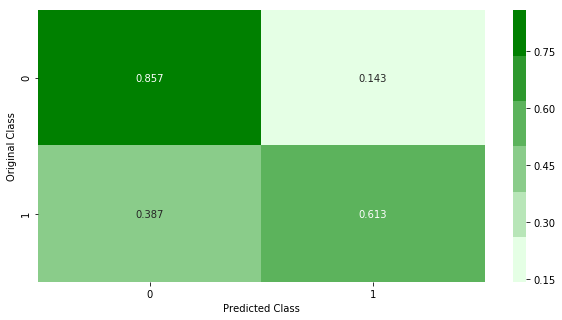

Sum of rows in precision matrix [1. 1.]


In [115]:
plot_confusion_matrix(test_output, predicted_test_failure)

__Summary:__
1. From the above heatmaps, scores, confusion matrix, we can observe that f1 score is less with SVM.
2. Best f1 score is with alpha=0.0001

    test_f1_score= 0.008735603766198983
    
    test Precison : 0.004399131240748682
    
    test Recall : 0.6133076181292189

### 10.3. Random Forest Classifier

In [109]:
n_estimators = [100,150,200]
max_depth = [7,  9]
train_f1_scores_rf=np.zeros((len(n_estimators),len(max_depth)),dtype=float)
cv_f1_scores_rf=np.zeros((len(n_estimators),len(max_depth)),dtype=float)
k=0
for i in n_estimators:
    print("For n_estimators:",i)
    train_f1_score=[]
    cv_f1_score=[]
    for j in max_depth:
        rf_model_imp = RandomForestClassifier(n_estimators=i, max_depth=j)
        rf_model_imp.fit(train_df_final_imp_1,train_output)
        cal_rf_model_imp=CalibratedClassifierCV(rf_model_imp,method='isotonic',cv='prefit')
        cal_rf_model_imp.fit(cv_df_final_imp_1,cv_output)

        train_scores_rf=cal_rf_model_imp.predict(train_df_final_imp_1)
        train_f1_score.append(f1_score(train_output,train_scores_rf))
        print("For max_depth=%d, train f1_score=%f" % (j,train_f1_score[-1]))
        print("Train Precison :",precision_score(train_output,train_scores_rf))
        print("Train Recall :",recall_score(train_output,train_scores_rf))
        

        cv_scores_rf=cal_rf_model_imp.predict(cv_df_final_imp_1)
        cv_f1_score.append(f1_score(cv_output,cv_scores_rf))
        print("For max_depth=%d, cv f1_score=%f" % (j,cv_f1_score[-1]))
        print("cv Precison :",precision_score(cv_output,cv_scores_rf))
        print("cv Recall :",recall_score(cv_output,cv_scores_rf))
        print("--"*50)
    

    train_f1_scores_rf[k]=train_f1_scores_rf[k]+np.array(train_f1_score)
    cv_f1_scores_rf[k]=cv_f1_scores_rf[k]+np.array(cv_f1_score)
    print("train_f1_scores_rf: ",train_f1_scores_rf[k])
    print("cv_f1_scores_rf: ",cv_f1_scores_rf[k])
    print("--"*50)
    k+=1

For n_estimators: 100
For max_depth=7, train f1_score=0.148796
Train Precison : 0.9991844052121124
Train Recall : 0.08038302182917405
For max_depth=7, cv f1_score=0.116649
cv Precison : 0.48672566371681414
cv Recall : 0.06626506024096386
----------------------------------------------------------------------------------------------------
For max_depth=9, train f1_score=0.272909
Train Precison : 0.9993228406248654
Train Recall : 0.158033179997914
For max_depth=9, cv f1_score=0.193548
cv Precison : 0.5129533678756477
cv Recall : 0.11927710843373494
----------------------------------------------------------------------------------------------------
train_f1_scores_rf:  [0.14879564 0.27290853]
cv_f1_scores_rf:  [0.11664899 0.19354839]
----------------------------------------------------------------------------------------------------
For n_estimators: 150
For max_depth=7, train f1_score=0.209319
Train Precison : 0.9993174187847409
Train Recall : 0.11690311766200574
For max_depth=7, cv f1_sc

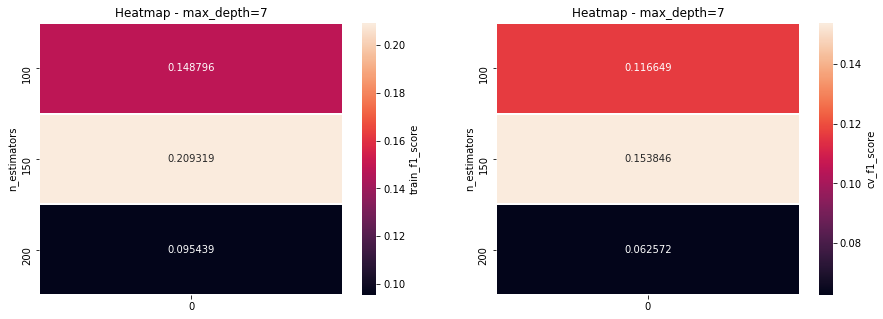

In [110]:
df1=pd.DataFrame(train_f1_scores_rf[:,0],index=n_estimators)
df2=pd.DataFrame(cv_f1_scores_rf[:,0],index=n_estimators)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(ylabel='n_estimators',title='Heatmap - max_depth=7')
plt.show()

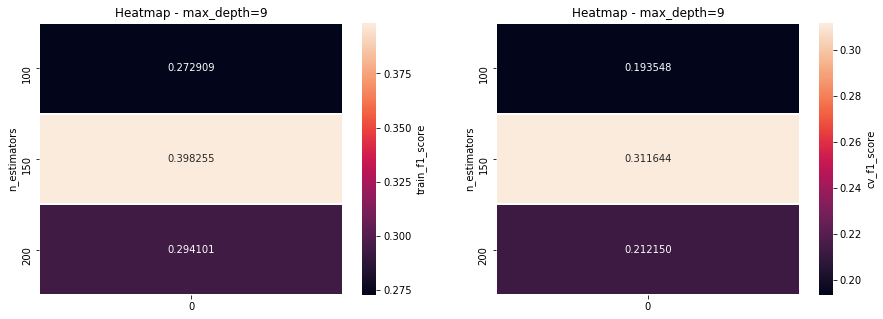

In [111]:
df1=pd.DataFrame(train_f1_scores_rf[:,1],index=n_estimators)
df2=pd.DataFrame(cv_f1_scores_rf[:,1],index=n_estimators)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(ylabel='n_estimators',title='Heatmap - max_depth=9')
plt.show()

__From the above heatmaps, we can observe that f1 score is high when n_estimators=150, depth=9.__

In [113]:
test_f1_score=[]
rf_model_imp = RandomForestClassifier(n_estimators=150, max_depth=9)
rf_model_imp.fit(train_df_final_imp_1,train_output)
cal_rf_model_imp=CalibratedClassifierCV(rf_model_imp,method='isotonic',cv='prefit')
cal_rf_model_imp.fit(cv_df_final_imp_1,cv_output)

test_scores_rf=cal_rf_model_imp.predict(test_df_final_imp_1)
test_f1_score.append(f1_score(test_output,test_scores_rf))
print("For max_depth=%d, test f1_score=%f" % (9,test_f1_score[-1]))
print("test Precison :",precision_score(test_output,test_scores_rf))
print("test Recall :",recall_score(test_output,test_scores_rf))

For max_depth=9, test f1_score=0.201405
test Precison : 0.5286885245901639
test Recall : 0.12439729990356799


Number of misclassified points  0.10121317294887498
------------------------- Confusion matrix -------------------------


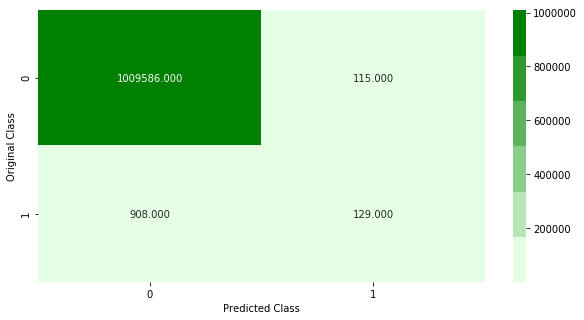

------------------------- Precision matrix -------------------------


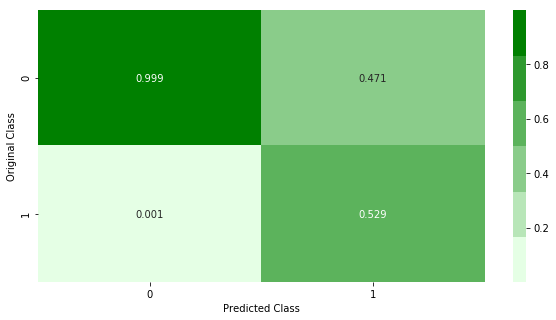

Sum of columns in precision matrix [1. 1.]
------------------------- Recall matrix -------------------------


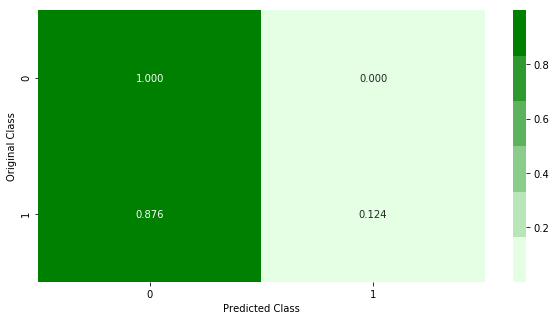

Sum of rows in precision matrix [1. 1.]


In [114]:
plot_confusion_matrix(test_output, test_scores_rf)

__Summary:__
1. From the above heatmaps, scores, confusion matrix, we can observe that f1 score is small with Random Forests but better than that with Logistic Regression and SVM.
2. With n_estimators=150, max_depth=9, we got the best f1 score.

    test f1_score=0.201405
    
    test Precison : 0.5286885245901639
    
    test Recall : 0.12439729990356799

### 10.4. XGBoost

In [118]:
#df_new=pd.read_csv('df_segate_july_august_no_backtrack.csv') rolling_mean 15, rolling_stdev 15,  exp_avg alpha=0.15, 
#expanding_mean, expanding_stdev
#upsampling, train_test_split 0.2, 15 days backtrack, model_imp_char_count, second_last chars, 
#serial second_last chars only working, calibration
n_estimators = [100, 150, 200, 500, 1000]
max_depth = [7, 9]
train_f1_scores_xgb=np.zeros((len(n_estimators),len(max_depth)),dtype=float)
cv_f1_scores_xgb=np.zeros((len(n_estimators),len(max_depth)),dtype=float)
k=0
for i in n_estimators:
    print("For n_estimators:",i)
    train_f1_score=[]
    cv_f1_score=[]
    for j in max_depth:
        xgb_model_imp = xgb.XGBClassifier(n_estimators=i, max_depth=j,tree_method='exact')
        xgb_model_imp.fit(train_df_final_imp_1,train_output)
        cal_xgb_model_imp=CalibratedClassifierCV(xgb_model_imp,method='isotonic',cv='prefit')
        cal_xgb_model_imp.fit(cv_df_final_imp_1,cv_output)

        train_scores_xgb=cal_xgb_model_imp.predict(train_df_final_imp_1)
        train_f1_score.append(f1_score(train_output,train_scores_xgb))
        print("For max_depth=%d, train f1_score=%f" % (j,train_f1_score[-1]))
        print("Train Precison :",precision_score(train_output,train_scores_xgb))
        print("Train Recall :",recall_score(train_output,train_scores_xgb))
        print("--"*50)
        
        cv_scores_xgb=cal_xgb_model_imp.predict(cv_df_final_imp_1)
        cv_f1_score.append(f1_score(cv_output,cv_scores_xgb))
        print("For max_depth=%d, cv f1_score=%f" % (j,cv_f1_score[-1]))
        print("cv Precison :",precision_score(cv_output,cv_scores_xgb))
        print("cv Recall :",recall_score(cv_output,cv_scores_xgb ))
        print("--"*50)

    print("--"*50)
    train_f1_scores_xgb[k]=train_f1_scores_xgb[k]+np.array(train_f1_score)
    cv_f1_scores_xgb[k]=cv_f1_scores_xgb[k]+np.array(cv_f1_score)
    print("train_f1_scores_xgb: ",train_f1_scores_xgb[k])
    print("cv_f1_scores_xgb: ",cv_f1_scores_xgb[k])
    k+=1

For n_estimators: 100
For max_depth=7, train f1_score=0.997667
Train Precison : 0.9999054905042828
Train Recall : 0.9954383151199164
----------------------------------------------------------------------------------------------------
For max_depth=7, cv f1_score=0.836897
cv Precison : 0.8488228004956629
cv Recall : 0.8253012048192772
----------------------------------------------------------------------------------------------------
For max_depth=9, train f1_score=0.999992
Train Precison : 0.9999845253603038
Train Recall : 1.0
----------------------------------------------------------------------------------------------------
For max_depth=9, cv f1_score=0.921942
cv Precison : 0.9410288582183187
cv Recall : 0.9036144578313253
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
train_f1_scores_xgb:  [0.9976669  0.99999226]
cv_f1_scores_xgb

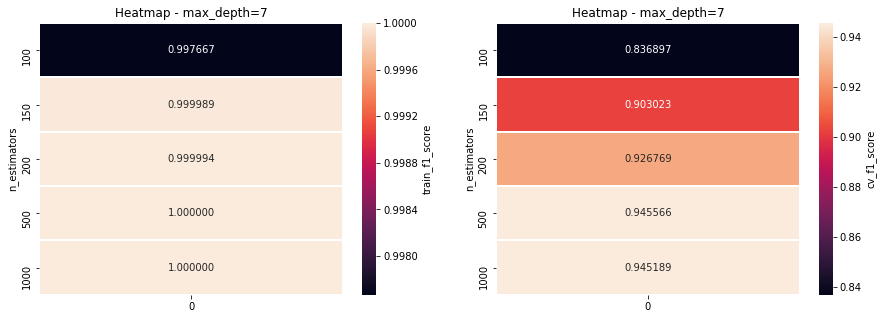

In [119]:
df1=pd.DataFrame(train_f1_scores_xgb[:,0],index=n_estimators)
df2=pd.DataFrame(cv_f1_scores_xgb[:,0],index=n_estimators)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
#heatmap cbar name - https://stackovexgblow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(ylabel='n_estimators',title='Heatmap - max_depth=7')
plt.show()

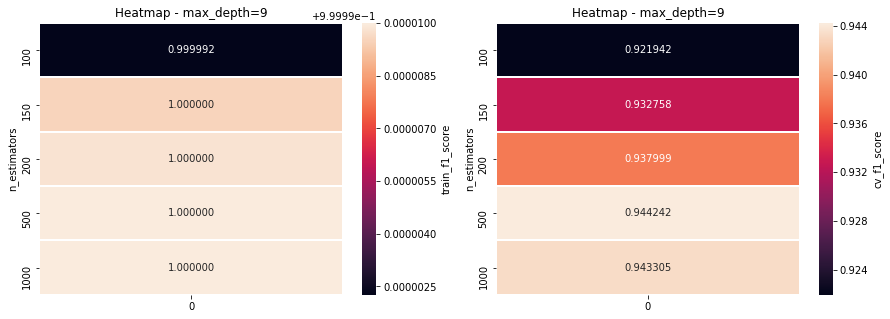

In [120]:
df1=pd.DataFrame(train_f1_scores_xgb[:,1],index=n_estimators)
df2=pd.DataFrame(cv_f1_scores_xgb[:,1],index=n_estimators)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
#heatmap cbar name - https://stackovexgblow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(ylabel='n_estimators',title='Heatmap - max_depth=9')
plt.show()

__From above scores and heatmaps, we can observe that f1 score is high when n_estimators=500 and max_depth=7. However we have good recall of 0.94 when n_estimators=1000 and max_depth=9. So testing with both of these combinations.__

####  n_estimators=500, max_depth=7

In [121]:
test_f1_score=[]
xgb_model_imp = xgb.XGBClassifier(n_estimators=500, max_depth=7,tree_method='exact')
xgb_model_imp.fit(train_df_final_imp_1,train_output)
cal_xgb_model_imp=CalibratedClassifierCV(xgb_model_imp,method='isotonic',cv='prefit')
cal_xgb_model_imp.fit(cv_df_final_imp_1,cv_output)

test_scores_xgb=cal_xgb_model_imp.predict(test_df_final_imp_1)
test_f1_score.append(f1_score(test_output,test_scores_xgb))
print("For max_depth=%d, test f1_score=%f" % (7,test_f1_score[-1]))
print("test Precison :",precision_score(test_output,test_scores_xgb))
print("test Recall :",recall_score(test_output,test_scores_xgb))

For max_depth=7, test f1_score=0.930049
test Precison : 0.9506545820745217
test Recall : 0.9103182256509161


Number of misclassified points  0.014049140331124385
------------------------- Confusion matrix -------------------------


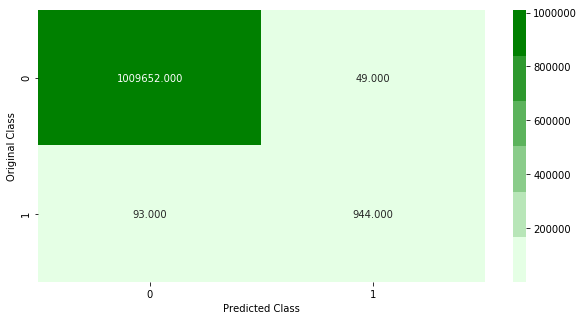

------------------------- Precision matrix -------------------------


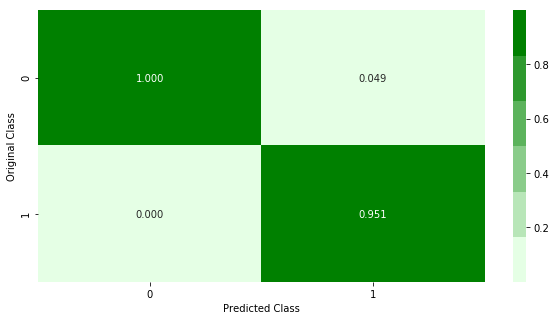

Sum of columns in precision matrix [1. 1.]
------------------------- Recall matrix -------------------------


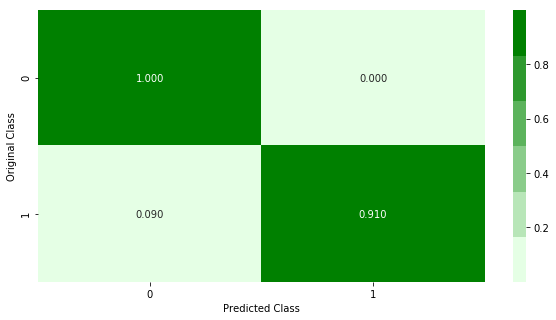

Sum of rows in precision matrix [1. 1.]


In [123]:
plot_confusion_matrix(test_output,test_scores_xgb)

#### n_estimators=1000, max_depth=9

In [221]:
test_f1_score_1=[]
xgb_model_imp_new = xgb.XGBClassifier(n_estimators=1000, max_depth=9,tree_method='exact')
xgb_model_imp_new.fit(train_df_final_imp_1,train_output)
cal_xgb_model_imp_new=CalibratedClassifierCV(xgb_model_imp_new,method='isotonic',cv='prefit')
cal_xgb_model_imp_new.fit(cv_df_final_imp_1,cv_output)

test_scores_xgb_new=cal_xgb_model_imp_new.predict(test_df_final_imp_1)
test_f1_score_1.append(f1_score(test_output,test_scores_xgb_new))
print("For max_depth=%d, test f1_score=%f" % (9,test_f1_score_1[-1]))
print("test Precison :",precision_score(test_output,test_scores_xgb_new))
print("test Recall :",recall_score(test_output,test_scores_xgb_new))

For max_depth=9, test f1_score=0.935266
test Precison : 0.9370764762826719
test Recall : 0.9334619093539055


In [561]:
pickle.dump(xgb_model_imp_new, open("xgb_model_imp_new.pickle.dat", "wb"))

In [562]:
pickle.dump(cal_xgb_model_imp_new, open("cal_xgb_model_imp_new.pickle.dat", "wb"))

Number of misclassified points  0.01325763946739907
------------------------- Confusion matrix -------------------------


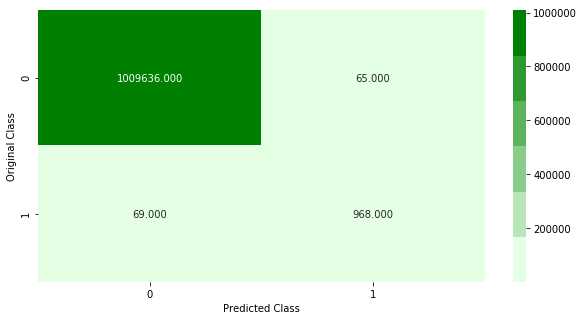

------------------------- Precision matrix -------------------------


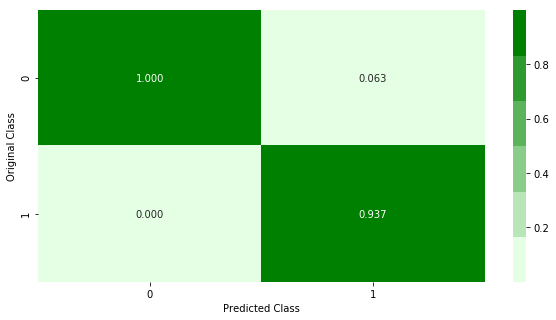

Sum of columns in precision matrix [1. 1.]
------------------------- Recall matrix -------------------------


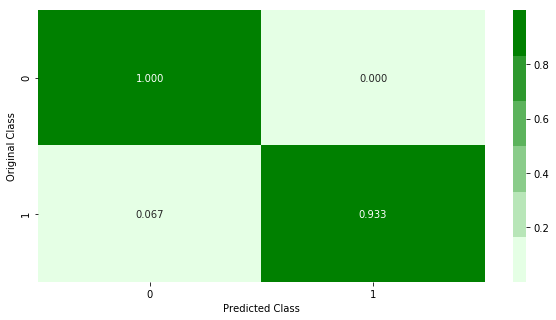

Sum of rows in precision matrix [1. 1.]


In [251]:
plot_confusion_matrix(test_output,test_scores_xgb_new)

__Summary:__
1. From the above heatmaps, scores, confusion matrix, we can observe that f1 score is good with XGBClassifier when compared with all other models.
2. With n_estimators=1000, max_depth=9, we got the best f1 score.

      test f1_score=0.935266
      
      test Precison : 0.9370764762826719
      
      test Recall : 0.9334619093539055

### 10.5. Naive Bayes

In [122]:
alpha_range=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
train_f1_scores_nb=[]
cv_f1_scores_nb=[]
for a in alpha_range:
    print("For alpha=",a)
    nb_clf_imp=MultinomialNB(alpha=a, fit_prior=True)
    nb_clf_imp.fit(train_normalized_imp,train_output)
    
    predicted_train_failure=nb_clf_imp.predict(train_normalized_imp)
    train_f1_scores_nb.append(f1_score(train_output, predicted_train_failure))
    print("Train Precison :",precision_score(train_output,predicted_train_failure))
    print("Train Recall :",recall_score(train_output,predicted_train_failure))
    print("train_f1_score=",train_f1_scores_nb[-1])
    print("-"*50)
    
    predicted_cv_failure=nb_clf_imp.predict(cv_normalized_imp)
    cv_f1_scores_nb.append(f1_score(cv_output, predicted_cv_failure))
    print("cv Precison :",precision_score(cv_output,predicted_cv_failure))
    print("cv Recall :",recall_score(cv_output,predicted_cv_failure))
    print("cv_f1_score=",cv_f1_scores_nb[-1])
    print("-"*50)
    
    print("-"*50)

For alpha= 0.0001
Train Precison : 0.6314096580883639
Train Recall : 0.7317389462164384
train_f1_score= 0.6778821272770801
--------------------------------------------------
cv Precison : 0.0016766467065868263
cv Recall : 0.7
cv_f1_score= 0.003345280764635603
--------------------------------------------------
--------------------------------------------------
For alpha= 0.001
Train Precison : 0.6314096580883639
Train Recall : 0.7317389462164384
train_f1_score= 0.6778821272770801
--------------------------------------------------
cv Precison : 0.0016766467065868263
cv Recall : 0.7
cv_f1_score= 0.003345280764635603
--------------------------------------------------
--------------------------------------------------
For alpha= 0.01
Train Precison : 0.6314096580883639
Train Recall : 0.7317389462164384
train_f1_score= 0.6778821272770801
--------------------------------------------------
cv Precison : 0.0016766467065868263
cv Recall : 0.7
cv_f1_score= 0.003345280764635603
-------------------

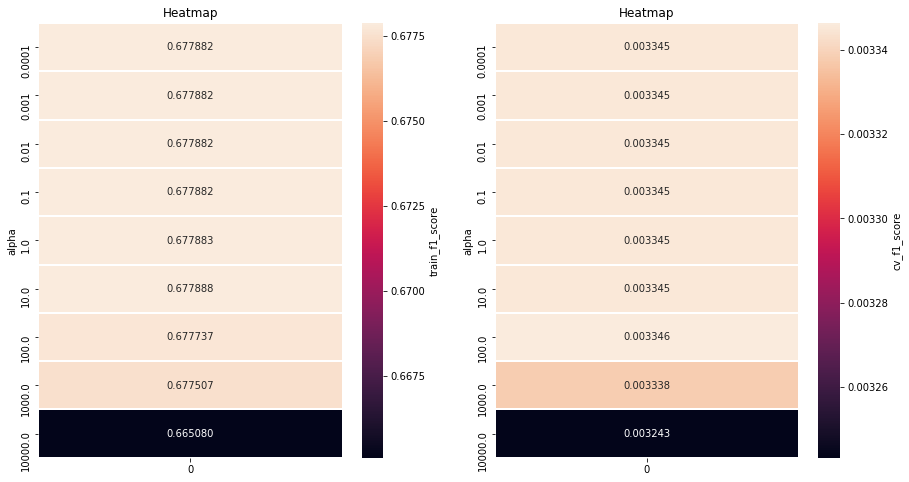

In [124]:
df1=pd.DataFrame(np.array(train_f1_scores_nb),index=alpha_range)
df2=pd.DataFrame(np.array(cv_f1_scores_nb),index=alpha_range)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
#heatmap cbar name - https://stackoverflow.com/questions/42092218/how-to-add-a-label
sb.heatmap(df1,annot=True,fmt="f",linewidths=1,ax=ax1,cbar_kws={'label': 'train_f1_score'})
sb.heatmap(df2,annot=True,fmt="f",linewidths=1,ax=ax2,cbar_kws={'label': 'cv_f1_score'})
for ax in (ax1,ax2):
 ax.set(ylabel='alpha',title='Heatmap')
plt.show()

__From the above heatmaps, we can observe that f1 score is high when alpha=10.__

In [126]:
test_f1_scores=[]
nb_clf_imp=MultinomialNB(alpha=10, fit_prior=True)
nb_clf_imp.fit(train_normalized_imp,train_output)
    
predicted_test_failure=nb_clf_imp.predict(test_normalized_imp)
test_f1_scores.append(f1_score(test_output, predicted_test_failure))
print("test Precison :",precision_score(test_output,predicted_test_failure))
print("test Recall :",recall_score(test_output,predicted_test_failure))
print("test_f1_score=",test_f1_scores[-1])

test Precison : 0.001737944741677163
test Recall : 0.7251687560270009
test_f1_score= 0.0034675790580358376


Number of misclassified points  42.76360441578332
------------------------- Confusion matrix -------------------------


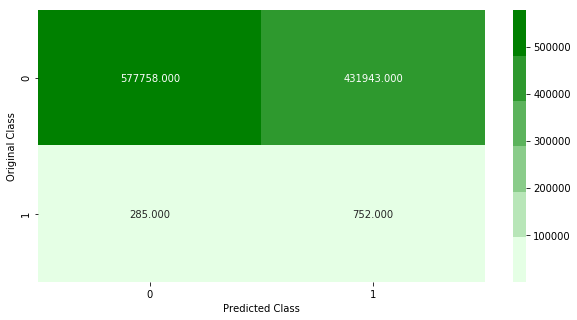

------------------------- Precision matrix -------------------------


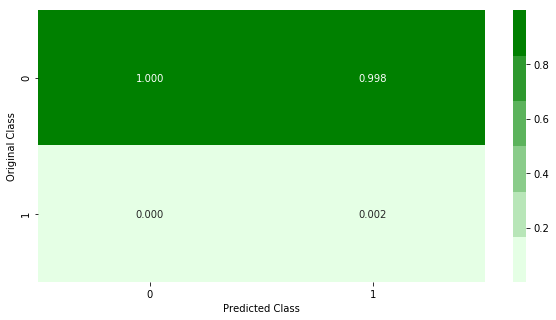

Sum of columns in precision matrix [1. 1.]
------------------------- Recall matrix -------------------------


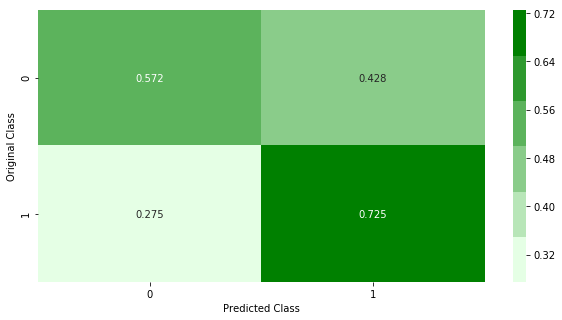

Sum of rows in precision matrix [1. 1.]


In [127]:
plot_confusion_matrix(test_output,predicted_test_failure)

__Summary:__
1. From the above heatmaps, scores, confusion matrix, we can observe that f1 score is small with Naive Bayes.
2. With alpha=10, we got the best f1 score.

    test_f1_score= 0.0034675790580358376
    
    test Precison : 0.001737944741677163
    
    test Recall : 0.7251687560270009

### 11. Ensemble of RandomForestClassifier and XGBClassifier

In [416]:
ensemble_vote_clf_imp = EnsembleVoteClassifier(clfs=[cal_rf_model_imp,cal_xgb_model_imp_new], voting='soft',refit=False,weights=[0.1,0.9])
ensemble_vote_clf_imp.fit(train_df_final_imp_1,train_output)
predicted_test_failure=ensemble_vote_clf_imp.predict(test_df_final_imp_1)
test_f1_scores.append(f1_score(test_output, predicted_test_failure))
print("test Precison :",precision_score(test_output,predicted_test_failure))
print("test Recall :",recall_score(test_output,predicted_test_failure))
print("test_f1_score=",test_f1_scores[-1])

test Precison : 0.9477317554240631
test Recall : 0.926711668273867
test_f1_score= 0.9371038517796197


In [559]:
pickle.dump(ensemble_vote_clf_imp, open("ensemble_vote_clf_imp.pickle.dat", "wb"))

## 12. Conclusion:

#### 12.1. Modelling with all features - summary

In [417]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Algorithm", "Hyper-parameters", "Precision Score", "Recall Score", "F1 Score"]
x.add_row(['Logistic Regression', 'C: 0.01, Penalty:  l2',0.004871,0.675024,0.009673])
x.add_row(['Support Vector Machine','alpha: 0.0001',0.005667,0.664416,0.011238])
x.add_row(['Random Forest Classifier','n_estimators: 150,max_depth: 9',0.736842,0.013500,0.026515])
x.add_row(['XGBClassifier','n_estimators: 1000, max_depth: 9',0.943339,0.915139,0.929026])
x.add_row(['Multinomial Navie Bayes','alpha: 10',0.002473,0.583413,0.004925])
print("Modelling with all features:")
print(x)

Modelling with all features:
+--------------------------+----------------------------------+-----------------+--------------+----------+
|        Algorithm         |         Hyper-parameters         | Precision Score | Recall Score | F1 Score |
+--------------------------+----------------------------------+-----------------+--------------+----------+
|   Logistic Regression    |      C: 0.01, Penalty:  l2       |     0.004871    |   0.675024   | 0.009673 |
|  Support Vector Machine  |          alpha: 0.0001           |     0.005667    |   0.664416   | 0.011238 |
| Random Forest Classifier |  n_estimators: 150,max_depth: 9  |     0.736842    |    0.0135    | 0.026515 |
|      XGBClassifier       | n_estimators: 1000, max_depth: 9 |     0.943339    |   0.915139   | 0.929026 |
| Multinomial Navie Bayes  |            alpha: 10             |     0.002473    |   0.583413   | 0.004925 |
+--------------------------+----------------------------------+-----------------+--------------+----------+

#### 12.2. Modelling with top 50 important features - summary

In [420]:
x = PrettyTable()
x.field_names = ["Algorithm", "Hyper-parameters", "Precision Score", "Recall Score", "F1 Score"]
x.add_row(['Logistic Regression', 'C: 100, Penalty:  l2',0.004196,0.631629,0.008338])
x.add_row(['Support Vector Machine','alpha: 0.0001',0.004399,0.613307,0.008735])
x.add_row(['Random Forest Classifier','n_estimators: 150,max_depth: 9',0.528688,0.124397,0.201405])
x.add_row(['XGBClassifier','n_estimators: 1000, max_depth: 9',0.937076,0.933461,0.935266])
x.add_row(['Multinomial Navie Bayes','alpha: 10',0.001737,0.725168,0.003467])
print("Modelling with top 50 important features:")
print(x)

Modelling with top 50 important features:
+--------------------------+----------------------------------+-----------------+--------------+----------+
|        Algorithm         |         Hyper-parameters         | Precision Score | Recall Score | F1 Score |
+--------------------------+----------------------------------+-----------------+--------------+----------+
|   Logistic Regression    |       C: 100, Penalty:  l2       |     0.004196    |   0.631629   | 0.008338 |
|  Support Vector Machine  |          alpha: 0.0001           |     0.004399    |   0.613307   | 0.008735 |
| Random Forest Classifier |  n_estimators: 150,max_depth: 9  |     0.528688    |   0.124397   | 0.201405 |
|      XGBClassifier       | n_estimators: 1000, max_depth: 9 |     0.937076    |   0.933461   | 0.935266 |
| Multinomial Navie Bayes  |            alpha: 10             |     0.001737    |   0.725168   | 0.003467 |
+--------------------------+----------------------------------+-----------------+-------------

__By comparing results of above two tables, we can observe that with top 50 important features we are able to get good scores. We got best f1 score with XGBClassifier.  The next good model is RandomForest but this doesn't perform that well.__

#### 12.3. Ensemble of RandomForestClassifier and XGBClassifier - summary

In [422]:
x = PrettyTable()
x.field_names = ["Algorithm", "Precision Score", "Recall Score", "F1 Score"]
x.add_row(['Ensemble of RF and XGB',0.947731,0.926711,0.937103])
print("Ensemble Modelling of RF and XGB with top 50 important features:")
print(x)

Ensemble Modelling of RF and XGB with top 50 important features:
+------------------------+-----------------+--------------+----------+
|       Algorithm        | Precision Score | Recall Score | F1 Score |
+------------------------+-----------------+--------------+----------+
| Ensemble of RF and XGB |     0.947731    |   0.926711   | 0.937103 |
+------------------------+-----------------+--------------+----------+


## Summary:
1. From the above tables, we can observe that precision is good with random forests and xgboost but is very less with other classifiers.
2. Recall is good with all classifiers except random forests.
3. XGBClassifier predicted failed hard drives very well.
4. Precision and recall scores are highest with XGBClassifier and also with ensemble of RF and XGB.
    
   #### XGB With top 50 important features:
  
    Test Precison : 0.937076

    Test Recall : 0.933461  -- Best
    
    Test f1_score: 0.935266
   
   #### Ensemble of XGB and RF With top 50 important features:
   
    Test Precison : 0.947731  -- Best

    Test Recall : 0.926711
    
    Test f1_score: 0.937103  -- Best
    
    We can observe that recall score is high with XGB classifier when top 50 features are used. Whereas f1score and precision are high with ensemble of XGB and RF with top 50 features. We can choose any of these two models. Both the models are good.
    
    
5. Extracted many time series features from given data like exponential averages, rolling mean, rolling standard deviation, expanding mean, expanding standard deviation, backtracked last 15 days' failures etc,.
6. Top 10 important features for XGBClassifier are:

    __smart_188_raw_exp_avg__
    
    __smart_5_raw__
    
    __smart_197_raw__
    
    __model_second_last_char_working__
    
    __capacity_bytes__
    
    __smart_199_raw_expanding_stdev__
    
    __serial_second_last_char_working__
    
    __smart_188_raw_expanding_mean__
    
    __smart_9_raw_rolling_mean__
    
    __smart_12_raw_rolling_stdev__
    
 
7. The above results are on SEGATE model hard drives' July and August months data. We can try with XGBoost modelling for other hard drives also. 

8. Recall is the important metric here. Our main aim to detect failed hard drives. In this case study, we have predicted hard drives that are going to fail in the next 15 days. If we can predict the drives that are going to fail few days before the failure, we can have sufficient time to retrieve data and replace them with new hard drives. It is somewhat fine if a drive predicted to be a failure is actually a working one. But the important aim here is recall: drives which are actually failures should be predicted as failures else if wrongly predicted as working ones, it may fail in future and data can't be retrieved.

    We got best recall score with XGBClassifier with top 50 important features: __0.933461__
    
    
8. Limited data to arorund 5 million due to limited system capacity. Train data is around 3 millions(after upsampling around 6 million)  With more amounts of data and feature engineering, we can further improve recall and f1 scores.